## To Do
##### ADD LEFT for TD_controls and surgical HEMI for nonOTC_controls
##### sub-008 crosses midline
##### register all to MNI for visualization
##### sub-018, 068, 079 are lost in pipeline
##### sub-108 will need to be added
##### consider age (development)
##### create a timeline comparison of controls to patients
##### worry about double dipping

Correct Group-Specific Summary (from your original results):
Spatial Drift Results:

OTC patients: Bilateral 12.4mm, Unilateral 11.5mm
nonOTC patients: Bilateral 4.5mm, Unilateral 7.1mm
Controls: Bilateral 8.4mm, Unilateral 8.0mm

Representational Change:

OTC patients: Bilateral 0.368, Unilateral 0.143 (difference: +0.226)
nonOTC patients: Bilateral 0.140, Unilateral 0.131 (difference: +0.008)
Controls: Bilateral 0.243, Unilateral 0.108 (difference: +0.134)

Key Finding: OTC patients show the strongest bilateral > unilateral representational plasticity (+0.226 difference), supporting neural crowding hypothesis - when visual cortex is removed, bilateral categories reorganize more than unilateral ones.

In [2]:
# Cell 1: Setup & Configuration (UPDATED)
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, label
import pandas as pd
from scipy.stats import pearsonr
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import seaborn as sns
from scipy.stats import linregress

# Use the CSV-driven configuration from the functional extraction notebook
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load subject info from CSV (same as functional extraction notebook)
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
df = pd.read_csv(CSV_FILE)
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

# Use the same subject loading function
def load_subjects_by_group(group_filter=None, patient_only=True):
    """Load subjects dynamically from CSV"""
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
            
        sessions = []
        for ses_dir in subj_dir.glob('ses-*'):
            if ses_dir.is_dir():
                sessions.append(ses_dir.name.replace('ses-', ''))
        
        if not sessions:
            continue
            
        sessions = sorted(sessions, key=lambda x: int(x))
        start_session = SESSION_START.get(subject_id, 1)
        available_sessions = [s for s in sessions if int(s) >= start_session]
        
        if not available_sessions:
            continue
            
        hemisphere_full = row.get('intact_hemi', 'left') if pd.notna(row.get('intact_hemi', None)) else 'left'
        hemisphere = 'l' if hemisphere_full == 'left' else 'r'
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': available_sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'age_1': row['age_1'] if pd.notna(row['age_1']) else None
        }
    
    return subjects

# Reload with correct hemisphere mapping
ALL_PATIENTS = load_subjects_by_group(group_filter=None, patient_only=True)
OTC_PATIENTS = load_subjects_by_group(group_filter='OTC', patient_only=True)
NON_OTC_PATIENTS = load_subjects_by_group(group_filter='nonOTC', patient_only=True)
ALL_CONTROLS = load_subjects_by_group(group_filter=None, patient_only=False)
ALL_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS} # Combine patients and controls

# Update analysis subjects
ANALYSIS_SUBJECTS = ALL_SUBJECTS

# NOTE ROI COPE MAP HERE MATCHES FUNCTIONAL EXTRACTION
#COPE_MAP = {
#    'face': 10,  # Updated to match functional extraction
#    'word': 12,
#    'object': 3,
#    'house': 11  # Updated to match functional extraction
#}


# COPE MAP HERE IS THE ONE WE WANT TO USE FOR RSA
COPE_MAP = {
    'face': 1,
    'word': 12,
    'object': 3,
    'house': 2
}

print(f"RSA Analysis - {len(ANALYSIS_SUBJECTS)} subjects loaded")
print("Subjects:", list(ANALYSIS_SUBJECTS.keys()))

RSA Analysis - 25 subjects loaded
Subjects: ['sub-004', 'sub-007', 'sub-008', 'sub-010', 'sub-017', 'sub-021', 'sub-045', 'sub-047', 'sub-049', 'sub-070', 'sub-072', 'sub-073', 'sub-079', 'sub-081', 'sub-086', 'sub-108', 'sub-018', 'sub-022', 'sub-025', 'sub-027', 'sub-052', 'sub-058', 'sub-062', 'sub-064', 'sub-068']


In [3]:
# Cell 2: Extract Functional ROIs (INTEGRATED)
from scipy.ndimage import label, center_of_mass

def extract_functional_rois_final(subject_id, subjects_dict, threshold_z=2.3):
    """Extract functional cluster ROIs across all sessions"""
    
    if subject_id not in subjects_dict:
        print(f"❌ {subject_id} not in analysis group")
        return {}
        
    info = subjects_dict[subject_id]
    code = info['code']
    hemi = info['hemi']
    sessions = info['sessions']
    first_session = sessions[0]
    
    print(f"\n{code} - Extracting Functional ROIs [{info['group']} {info['patient_status']}]")
    
    all_results = {}
    
    # Process each category using COPE_MAP
    for category, cope_num in COPE_MAP.items():
        all_results[category] = {}
        
        # Load category-specific mask
        mask_file = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            print(f"  ⚠️  {category}: mask not found")
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        # Process each session
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            
            # Select correct zstat file
            zstat_file = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            # Load functional activation
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:
                continue
            
            # Find largest cluster
            labeled, n_clusters = label(suprathresh)
            if n_clusters == 0:
                continue
                
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            # Extract metrics
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            peak_z = zstat[peak_idx]
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            # Store results
            all_results[category][session] = {
                'n_voxels': cluster_sizes[largest_idx - 1],
                'peak_z': peak_z,
                'centroid': centroid,
                'roi_mask': roi_mask
            }
    
    return all_results

# Extract functional ROIs for all analysis subjects
print("="*70)
print("EXTRACTING FUNCTIONAL ROIs FOR RSA ANALYSIS")
print("="*70)

golarai_functional_final = {}

for subject_id in ANALYSIS_SUBJECTS.keys():
    try:
        golarai_functional_final[subject_id] = extract_functional_rois_final(subject_id, ANALYSIS_SUBJECTS, threshold_z=2.3)
    except Exception as e:
        print(f"❌ {subject_id} failed: {e}")
        golarai_functional_final[subject_id] = {}

print(f"\n✓ Functional ROI extraction complete for {len(golarai_functional_final)} subjects!")

# Quick summary
for subject_id, results in golarai_functional_final.items():
    if subject_id in ANALYSIS_SUBJECTS:
        code = ANALYSIS_SUBJECTS[subject_id]['code']
        categories = list(results.keys())
        total_sessions = sum(len(sessions) for sessions in results.values())
        print(f"  {code}: {len(categories)} categories, {total_sessions} total ROIs")

EXTRACTING FUNCTIONAL ROIs FOR RSA ANALYSIS

OTC004 - Extracting Functional ROIs [OTC patient]



nonOTC007 - Extracting Functional ROIs [nonOTC patient]

OTC008 - Extracting Functional ROIs [OTC patient]

OTC010 - Extracting Functional ROIs [OTC patient]

OTC017 - Extracting Functional ROIs [OTC patient]

OTC021 - Extracting Functional ROIs [OTC patient]

nonOTC045 - Extracting Functional ROIs [nonOTC patient]

nonOTC047 - Extracting Functional ROIs [nonOTC patient]

nonOTC049 - Extracting Functional ROIs [nonOTC patient]

nonOTC070 - Extracting Functional ROIs [nonOTC patient]

nonOTC072 - Extracting Functional ROIs [nonOTC patient]

nonOTC073 - Extracting Functional ROIs [nonOTC patient]

OTC079 - Extracting Functional ROIs [OTC patient]

nonOTC081 - Extracting Functional ROIs [nonOTC patient]

nonOTC086 - Extracting Functional ROIs [nonOTC patient]

OTC108 - Extracting Functional ROIs [OTC patient]
  ⚠️  face: mask not found
  ⚠️  word: mask not found
  ⚠️  object: mask not found
  ⚠️  house: mask not found

control018 - Extracting Functional ROIs [control control]
  ⚠️  face:

In [4]:
# Cell 3: RSA Helper Functions (UPDATED)
def create_6mm_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create a 6mm sphere around a peak."""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]), 
        np.arange(brain_shape[1]), 
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

def extract_beta_patterns_from_sphere(subject_id, session, sphere_mask, category_copes):
    """Extract beta values from a 6mm sphere for all categories."""
    info = ANALYSIS_SUBJECTS[subject_id]  # UPDATED: Use ANALYSIS_SUBJECTS
    first_session = info['sessions'][0]
    
    feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
    
    beta_patterns = []
    valid_categories = []
    
    for category, cope_num in category_copes.items():
        # UPDATED: Use correct file naming based on session
        if session == first_session:
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
        else:
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / f'cope1_ses{first_session}.nii.gz'
        
        if not cope_file.exists():
            continue
        
        cope_data = nib.load(cope_file).get_fdata()
        roi_betas = cope_data[sphere_mask]
        roi_betas = roi_betas[np.isfinite(roi_betas)]
        
        if len(roi_betas) > 0:
            beta_patterns.append(roi_betas)
            valid_categories.append(category)
    
    if len(beta_patterns) == 0:
        return None, None
    
    min_voxels = min(len(b) for b in beta_patterns)
    beta_patterns = [b[:min_voxels] for b in beta_patterns]
    beta_matrix = np.column_stack(beta_patterns)
    
    return beta_matrix, valid_categories

def compute_rdm(beta_matrix, fisher_transform=True):
    """Compute Representational Dissimilarity Matrix."""
    correlation_matrix = np.corrcoef(beta_matrix.T)
    rdm = 1 - correlation_matrix
    
    if fisher_transform:
        correlation_matrix_fisher = np.arctanh(np.clip(correlation_matrix, -0.999, 0.999))
        return rdm, correlation_matrix_fisher
    else:
        return rdm, correlation_matrix

print("✓ RSA helper functions updated")

✓ RSA helper functions updated


In [5]:
# Cell 4: Session-Specific RSA Analysis (UPDATED)
def extract_all_rdms_6mm_session_specific(functional_results, analysis_subjects):
    """Extract RDMs from 6mm spheres using SESSION-SPECIFIC ROIs - UPDATED"""
    all_rdms = {}
    
    for subject_id in analysis_subjects.keys():  # UPDATED: Use analysis_subjects
        if subject_id not in functional_results:
            continue
            
        info = analysis_subjects[subject_id]  # UPDATED: Use analysis_subjects
        code = info['code']
        hemi = info['hemi']
        sessions = info['sessions']
        first_session = sessions[0]
        
        # UPDATED: Use first session for reference
        ref_file = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        if not ref_file.exists():
            print(f"⚠️ Reference file missing for {code}: {ref_file}")
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        print(f"\n{code} ({info['group']} {info['patient_status']}): SESSION-SPECIFIC RSA Analysis")
        
        all_rdms[subject_id] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            if roi_name not in functional_results[subject_id]:
                continue
            
            all_rdms[subject_id][roi_name] = {
                'rdms': {},
                'correlation_matrices': {},
                'beta_patterns': {},
                'valid_categories': None,
                'session_peaks': {},
                'session_n_voxels': {}
            }
            
            for session in sessions:
                if session not in functional_results[subject_id][roi_name]:
                    continue
                
                # SESSION-SPECIFIC peak and sphere
                peak = functional_results[subject_id][roi_name][session]['centroid']
                sphere_mask = create_6mm_sphere(peak, affine, brain_shape, radius=6)
                n_voxels = sphere_mask.sum()
                
                all_rdms[subject_id][roi_name]['session_peaks'][session] = peak
                all_rdms[subject_id][roi_name]['session_n_voxels'][session] = n_voxels
                
                beta_matrix, valid_cats = extract_beta_patterns_from_sphere(
                    subject_id, session, sphere_mask, COPE_MAP  # UPDATED: Use COPE_MAP
                )
                
                if beta_matrix is None:
                    continue
                
                rdm, corr_matrix_fisher = compute_rdm(beta_matrix, fisher_transform=True)
                
                all_rdms[subject_id][roi_name]['rdms'][session] = rdm
                all_rdms[subject_id][roi_name]['correlation_matrices'][session] = corr_matrix_fisher
                all_rdms[subject_id][roi_name]['beta_patterns'][session] = beta_matrix
                all_rdms[subject_id][roi_name]['valid_categories'] = valid_cats
                
                print(f"  {roi_name} ses-{session}: {n_voxels} voxels")
    
    return all_rdms

# Run with session-specific ROIs
print("STEP 1: SESSION-SPECIFIC ROI RSA")
print("="*70)
rsa_rdms_6mm_session_specific = extract_all_rdms_6mm_session_specific(golarai_functional_final, ANALYSIS_SUBJECTS)
print("✓ Session-specific analysis complete!")

STEP 1: SESSION-SPECIFIC ROI RSA

OTC004 (OTC patient): SESSION-SPECIFIC RSA Analysis
  face ses-02: 906 voxels
  face ses-03: 903 voxels
  face ses-05: 899 voxels
  face ses-06: 903 voxels
  word ses-02: 898 voxels
  word ses-03: 904 voxels
  word ses-05: 913 voxels
  word ses-06: 898 voxels
  object ses-01: 905 voxels
  object ses-02: 906 voxels
  object ses-03: 903 voxels
  object ses-05: 911 voxels
  object ses-06: 904 voxels
  house ses-01: 897 voxels
  house ses-02: 918 voxels
  house ses-03: 914 voxels
  house ses-05: 900 voxels
  house ses-06: 902 voxels

nonOTC007 (nonOTC patient): SESSION-SPECIFIC RSA Analysis
  face ses-01: 909 voxels
  face ses-03: 909 voxels
  face ses-04: 905 voxels
  word ses-03: 905 voxels
  word ses-04: 905 voxels
  object ses-01: 916 voxels
  object ses-03: 912 voxels
  object ses-04: 908 voxels
  house ses-01: 916 voxels
  house ses-03: 904 voxels
  house ses-04: 906 voxels

OTC008 (OTC patient): SESSION-SPECIFIC RSA Analysis
  face ses-01: 898 voxel

In [6]:
# Cell 5: Liu's RSA Methodology (UPDATED)
def compute_liu_distinctiveness(all_rdms, analysis_subjects):
    """Compute Liu's preferred vs non-preferred category correlations - UPDATED"""
    roi_preferred = {'face': 'face', 'word': 'word', 'object': 'object', 'house': 'house'}
    
    distinctiveness_results = {}
    
    for subject_id, categories in all_rdms.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        
        distinctiveness_results[subject_id] = {}
        
        print(f"\n{code} ({group_status}): Liu's Distinctiveness Analysis")
        
        for roi_name, roi_data in categories.items():
            if not roi_data['correlation_matrices']:
                continue
            
            valid_cats = roi_data['valid_categories']
            if valid_cats is None or len(valid_cats) < 4:
                continue
            
            preferred_cat = roi_preferred[roi_name]
            if preferred_cat not in valid_cats:
                continue
            
            pref_idx = valid_cats.index(preferred_cat)
            nonpref_indices = [i for i, cat in enumerate(valid_cats) if cat != preferred_cat]
            
            distinctiveness_results[subject_id][roi_name] = {}
            
            for session, corr_matrix in roi_data['correlation_matrices'].items():
                pref_vs_nonpref = corr_matrix[pref_idx, nonpref_indices]
                mean_corr = np.mean(pref_vs_nonpref)
                
                distinctiveness_results[subject_id][roi_name][session] = {
                    'liu_distinctiveness': mean_corr,
                    'individual_correlations': pref_vs_nonpref
                }
                
                print(f"  {roi_name} ses-{session}: {mean_corr:.3f}")
    
    return distinctiveness_results

def compute_liu_bootstrapped_slopes(all_rdms, analysis_subjects, n_bootstraps=1000):
    """Liu's bootstrapped linear regression for dissimilarity changes - UPDATED"""
    from scipy.stats import linregress
    
    slope_results = {}
    pairs = [('face', 'word'), ('house', 'object'), ('face', 'object'), ('word', 'house')]
    
    for subject_id, categories in all_rdms.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        sessions = info['sessions']
        
        slope_results[subject_id] = {}
        
        print(f"\n{code}: Liu's Bootstrapped Slope Analysis")
        
        for roi_name, roi_data in categories.items():
            if not roi_data['rdms']:
                continue
            
            valid_cats = roi_data['valid_categories']
            if valid_cats is None or len(valid_cats) < 4:
                continue
            
            slope_results[subject_id][roi_name] = {}
            
            for cat1, cat2 in pairs:
                if cat1 not in valid_cats or cat2 not in valid_cats:
                    continue
                
                idx1, idx2 = valid_cats.index(cat1), valid_cats.index(cat2)
                
                session_nums, dissims = [], []
                for session in sessions:
                    if session in roi_data['rdms']:
                        rdm = roi_data['rdms'][session]
                        dissim = rdm[idx1, idx2]
                        session_nums.append(int(session))
                        dissims.append(dissim)
                
                if len(session_nums) < 2:
                    continue
                
                slope = linregress(session_nums, dissims)[0]
                
                null_slopes = []
                for _ in range(n_bootstraps):
                    shuffled = np.random.permutation(dissims)
                    null_slope = linregress(session_nums, shuffled)[0]
                    null_slopes.append(null_slope)
                
                ci_lower = np.percentile(null_slopes, 2.5)
                ci_upper = np.percentile(null_slopes, 97.5)
                significant = slope < ci_lower or slope > ci_upper
                
                slope_results[subject_id][roi_name][f'{cat1}-{cat2}'] = {
                    'observed_slope': slope,
                    'null_slopes': null_slopes,
                    'ci_95': (ci_lower, ci_upper),
                    'significant': significant
                }
                
                sig = "***" if significant else "n.s."
                print(f"  {roi_name} {cat1}-{cat2}: {slope:.4f} {sig}")
    
    return slope_results

# Run Liu's analyses (UPDATED to use ANALYSIS_SUBJECTS)
print("STEP 2: LIU'S RSA METHODOLOGY")
print("="*70)
liu_distinctiveness = compute_liu_distinctiveness(rsa_rdms_6mm_session_specific, ANALYSIS_SUBJECTS)
liu_slopes = compute_liu_bootstrapped_slopes(rsa_rdms_6mm_session_specific, ANALYSIS_SUBJECTS)
print("✓ Liu's methodology complete!")

STEP 2: LIU'S RSA METHODOLOGY

OTC004 (OTC patient): Liu's Distinctiveness Analysis
  face ses-02: 0.346
  face ses-03: -0.025
  face ses-05: 0.103
  face ses-06: 0.128
  word ses-02: 0.097
  word ses-03: 0.658
  word ses-05: 0.246
  word ses-06: 0.179
  object ses-01: -0.352
  object ses-02: -0.891
  object ses-03: -0.293
  object ses-05: -0.531
  object ses-06: -0.451
  house ses-01: -0.928
  house ses-02: -0.872
  house ses-03: -0.369
  house ses-05: -1.008
  house ses-06: -0.441

nonOTC007 (nonOTC patient): Liu's Distinctiveness Analysis
  face ses-01: 0.275
  face ses-03: 0.113
  face ses-04: 0.235
  word ses-03: -0.059
  word ses-04: -0.043
  object ses-01: -0.233
  object ses-03: 0.229
  object ses-04: -0.125
  house ses-01: -0.256
  house ses-03: -0.700
  house ses-04: -0.163

OTC008 (OTC patient): Liu's Distinctiveness Analysis
  face ses-01: 0.372
  face ses-02: 0.469
  word ses-02: -0.023
  object ses-01: 0.801
  object ses-02: 0.052
  house ses-01: -0.081
  house ses-02: -0

In [7]:
# CELL 6: CALCULATE MEASUREMENT ERROR RADII (UPDATED)
def get_bootstrapped_error_radius(pair_peaks, n_bootstraps=1000):
    """Calculate bootstrapped measurement error radius."""
    if not pair_peaks or len(pair_peaks) < 2:
        return 1.0
    
    data = np.array([p['coord'][:2] for p in pair_peaks])
    
    def stat_func(coords):
        if len(np.unique(coords[:, 0])) < 2 or len(np.unique(coords[:, 1])) < 2:
            return 0.0
        return np.sqrt(np.std(coords[:, 0])**2 + np.std(coords[:, 1])**2)
    
    bootstrapped_stats = [stat_func(data[np.random.choice(len(data), len(data), replace=True)]) 
                          for _ in range(n_bootstraps)]
    
    final_radius = np.mean(bootstrapped_stats)
    return final_radius if not np.isnan(final_radius) and final_radius > 0 else stat_func(data)

def calculate_error_radii_for_subjects(functional_results, analysis_subjects):
    """Calculate measurement error radii for all subjects"""
    radii = {}
    
    for subject_id in analysis_subjects.keys():
        if subject_id not in functional_results:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        radii[subject_id] = {}
        
        print(f"\n{code} - Calculating error radii:")
        
        for category, sessions_data in functional_results[subject_id].items():
            if len(sessions_data) < 2:
                radii[subject_id][category] = 1.0  # Default radius
                print(f"  {category}: 1.0mm (default - insufficient sessions)")
                continue
            
            # Collect peak coordinates for bootstrapping
            pair_peaks = []
            for session, data in sessions_data.items():
                pair_peaks.append({
                    'coord': data['centroid'],
                    'session': session
                })
            
            radius = get_bootstrapped_error_radius(pair_peaks)
            radii[subject_id][category] = radius
            print(f"  {category}: {radius:.2f}mm")
    
    return radii

# Calculate radii for all analysis subjects
print("CALCULATING MEASUREMENT ERROR RADII")
print("="*70)
radii = calculate_error_radii_for_subjects(golarai_functional_final, ANALYSIS_SUBJECTS)
print("✓ Error radii calculated!")

CALCULATING MEASUREMENT ERROR RADII

OTC004 - Calculating error radii:
  face: 7.65mm
  word: 9.14mm
  object: 1.36mm
  house: 5.17mm

nonOTC007 - Calculating error radii:
  face: 3.18mm
  word: 3.80mm
  object: 1.67mm
  house: 13.17mm

OTC008 - Calculating error radii:
  face: 0.98mm
  word: 1.0mm (default - insufficient sessions)
  object: 2.73mm
  house: 4.02mm

OTC010 - Calculating error radii:
  face: 0.40mm
  word: 5.30mm
  object: 0.65mm
  house: 2.72mm

OTC017 - Calculating error radii:
  face: 3.82mm
  word: 18.19mm
  object: 1.86mm
  house: 18.54mm

OTC021 - Calculating error radii:
  face: 0.56mm
  word: 4.01mm
  object: 1.41mm
  house: 5.50mm

nonOTC045 - Calculating error radii:
  face: 1.98mm
  word: 0.36mm
  object: 0.35mm
  house: 1.29mm

nonOTC047 - Calculating error radii:
  face: 0.38mm
  word: 0.57mm
  object: 0.21mm
  house: 2.58mm

nonOTC049 - Calculating error radii:
  face: 0.24mm
  word: 0.54mm
  object: 0.55mm
  house: 0.65mm

nonOTC070 - Calculating error rad

In [8]:
# CELL 7: DRIFT ANALYSIS (UPDATED)
def calculate_centroid_drift(functional_results, radii, analysis_subjects):
    """Calculate drift between sessions for each category - UPDATED"""
    drift_results = {}
    
    for subject_id, categories in functional_results.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        
        drift_results[subject_id] = {}
        
        print(f"\n{code} ({group_status}): Centroid Drift Analysis")
        
        for category, sessions_data in categories.items():
            if len(sessions_data) < 2:
                continue
            
            sessions = sorted(sessions_data.keys())
            baseline_session = sessions[0]
            baseline_centroid = sessions_data[baseline_session]['centroid']
            error_radius = radii[subject_id].get(category, 1.0)
            
            drift_results[subject_id][category] = {
                'baseline_session': baseline_session,
                'baseline_centroid': baseline_centroid,
                'error_radius': error_radius,
                'from_baseline_drift': []
            }
            
            # Calculate drift from baseline
            for session in sessions[1:]:
                current_centroid = sessions_data[session]['centroid']
                drift_from_baseline = np.linalg.norm(current_centroid - baseline_centroid)
                
                drift_results[subject_id][category]['from_baseline_drift'].append({
                    'session': session,
                    'distance_mm': drift_from_baseline,
                    'relative_to_error': drift_from_baseline / error_radius
                })
                
                print(f"  {category} ses-{session}: {drift_from_baseline:.2f}mm drift (error radius: {error_radius:.2f}mm)")
    
    return drift_results

# Run drift analysis
print("CALCULATING CENTROID DRIFT")
print("="*70)
drift_data = calculate_centroid_drift(golarai_functional_final, radii, ANALYSIS_SUBJECTS)
print("✓ Drift analysis complete!")

CALCULATING CENTROID DRIFT

OTC004 (OTC patient): Centroid Drift Analysis
  face ses-03: 23.26mm drift (error radius: 7.65mm)
  face ses-05: 24.40mm drift (error radius: 7.65mm)
  face ses-06: 15.05mm drift (error radius: 7.65mm)
  word ses-03: 18.50mm drift (error radius: 9.14mm)
  word ses-05: 1.81mm drift (error radius: 9.14mm)
  word ses-06: 24.41mm drift (error radius: 9.14mm)
  object ses-02: 2.74mm drift (error radius: 1.36mm)
  object ses-03: 4.15mm drift (error radius: 1.36mm)
  object ses-05: 4.18mm drift (error radius: 1.36mm)
  object ses-06: 3.15mm drift (error radius: 1.36mm)
  house ses-02: 2.68mm drift (error radius: 5.17mm)
  house ses-03: 3.18mm drift (error radius: 5.17mm)
  house ses-05: 2.14mm drift (error radius: 5.17mm)
  house ses-06: 15.66mm drift (error radius: 5.17mm)

nonOTC007 (nonOTC patient): Centroid Drift Analysis
  face ses-03: 8.49mm drift (error radius: 3.18mm)
  face ses-04: 3.46mm drift (error radius: 3.18mm)
  word ses-04: 18.53mm drift (error rad

In [9]:
# CELL 8: BILATERAL VS UNILATERAL CATEGORY ANALYSIS (UPDATED)
def analyze_bilateral_vs_unilateral(drift_data, distinctiveness_results, slope_results, analysis_subjects):
    """
    Comprehensive analysis comparing bilateral vs unilateral categories - UPDATED
    """
    
    # Category groupings
    bilateral_categories = ['object', 'house']
    unilateral_categories = ['face', 'word']
    
    results = {
        'spatial_drift': {},
        'representational_stability': {},
        'reorganization_patterns': {}
    }
    
    print("BILATERAL vs UNILATERAL CATEGORY ANALYSIS")
    print("="*70)
    
    # ============================================================================
    # PART 1: SPATIAL DRIFT COMPARISON
    # ============================================================================
    
    print("\n1. SPATIAL DRIFT ANALYSIS")
    print("-" * 40)
    
    all_bilateral_drift = []
    all_unilateral_drift = []
    
    for subject_id, categories in drift_data.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        
        print(f"\n{code} ({group_status}):")
        
        subject_bilateral = []
        subject_unilateral = []
        
        for category, data in categories.items():
            if not data['from_baseline_drift']:
                continue
            
            # Get maximum drift from baseline
            max_drift = max([d['distance_mm'] for d in data['from_baseline_drift']])
            mean_drift = np.mean([d['distance_mm'] for d in data['from_baseline_drift']])
            
            if category in bilateral_categories:
                subject_bilateral.append(mean_drift)
                all_bilateral_drift.append(mean_drift)
                print(f"  {category} (bilateral): {mean_drift:.2f}mm avg drift")
            elif category in unilateral_categories:
                subject_unilateral.append(mean_drift)
                all_unilateral_drift.append(mean_drift)
                print(f"  {category} (unilateral): {mean_drift:.2f}mm avg drift")
        
        # Subject-level comparison
        if subject_bilateral and subject_unilateral:
            bilateral_avg = np.mean(subject_bilateral)
            unilateral_avg = np.mean(subject_unilateral)
            print(f"  → Bilateral avg: {bilateral_avg:.2f}mm")
            print(f"  → Unilateral avg: {unilateral_avg:.2f}mm")
            print(f"  → Difference: {unilateral_avg - bilateral_avg:.2f}mm")
    
    # Overall statistics
    if all_bilateral_drift and all_unilateral_drift:
        from scipy.stats import ttest_ind
        
        print(f"\nOVERALL SPATIAL DRIFT COMPARISON:")
        print(f"Bilateral categories: {np.mean(all_bilateral_drift):.2f} ± {np.std(all_bilateral_drift):.2f}mm")
        print(f"Unilateral categories: {np.mean(all_unilateral_drift):.2f} ± {np.std(all_unilateral_drift):.2f}mm")
        
        stat, p_val = ttest_ind(all_bilateral_drift, all_unilateral_drift)
        print(f"t-test: t={stat:.3f}, p={p_val:.3f}")
        
        results['spatial_drift'] = {
            'bilateral_drifts': all_bilateral_drift,
            'unilateral_drifts': all_unilateral_drift,
            'bilateral_mean': np.mean(all_bilateral_drift),
            'unilateral_mean': np.mean(all_unilateral_drift),
            'test_statistic': stat,
            'p_value': p_val
        }
    
    return results

# Note: You'll need to add distinctiveness_results and slope_results analysis first
# For now, run with just drift data:
print("Running bilateral vs unilateral analysis with available data...")

# Simplified version focusing on spatial drift only
bilateral_vs_unilateral_results = analyze_bilateral_vs_unilateral(
    drift_data, {}, {}, ANALYSIS_SUBJECTS  # Empty dicts for missing analyses
)

Running bilateral vs unilateral analysis with available data...
BILATERAL vs UNILATERAL CATEGORY ANALYSIS

1. SPATIAL DRIFT ANALYSIS
----------------------------------------

OTC004 (OTC patient):
  face (unilateral): 20.90mm avg drift
  word (unilateral): 14.91mm avg drift
  object (bilateral): 3.56mm avg drift
  house (bilateral): 5.91mm avg drift
  → Bilateral avg: 4.74mm
  → Unilateral avg: 17.90mm
  → Difference: 13.17mm

nonOTC007 (nonOTC patient):
  face (unilateral): 5.97mm avg drift
  word (unilateral): 18.53mm avg drift
  object (bilateral): 4.67mm avg drift
  house (bilateral): 22.84mm avg drift
  → Bilateral avg: 13.76mm
  → Unilateral avg: 12.25mm
  → Difference: -1.51mm

OTC008 (OTC patient):
  face (unilateral): 4.13mm avg drift
  object (bilateral): 11.37mm avg drift
  house (bilateral): 17.59mm avg drift
  → Bilateral avg: 14.48mm
  → Unilateral avg: 4.13mm
  → Difference: -10.35mm

OTC010 (OTC patient):
  face (unilateral): 3.54mm avg drift
  word (unilateral): 22.07m

In [10]:
# CELL 9: Complete Coupling Analysis
def analyze_spatial_representational_coupling_complete_with_exclusion(drift_data, distinctiveness_data, analysis_subjects):
    """
    Complete spatial-representational coupling analysis with simple subject exclusion
    """
    
    # SIMPLE EXCLUSION LIST - just add subjects here as needed
    subjects_to_skip = ['OTC079', 'OTC108', 'control068']  # Add others if they have all zeros
    
    print("FINAL ANALYSIS: SPATIAL-REPRESENTATIONAL COUPLING (COMPLETE)")
    print("="*80)
    print(f"Excluding subjects: {subjects_to_skip}")
    
    bilateral_categories = ['object', 'house']
    unilateral_categories = ['face', 'word']
    
    results = {}
    
    for subject_id in analysis_subjects.keys():
        # SKIP EXCLUDED SUBJECTS
        if analysis_subjects[subject_id]['code'] in subjects_to_skip:
            continue
            
        if subject_id not in drift_data:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        
        print(f"\n{code} ({group_status})")
        print("-" * 50)
        
        results[subject_id] = {
            'spatial_changes': {},
            'representational_changes': {},
            'coupling_data': []
        }
        
        # Calculate change scores for each ROI
        for category in ['face', 'word', 'object', 'house']:
            
            # SPATIAL CHANGE: Mean drift from baseline
            if (category in drift_data.get(subject_id, {}) and 
                drift_data[subject_id][category]['from_baseline_drift']):
                
                spatial_drifts = [d['distance_mm'] for d in drift_data[subject_id][category]['from_baseline_drift']]
                mean_spatial_change = np.mean(spatial_drifts)
            else:
                mean_spatial_change = 0
            
            # REPRESENTATIONAL CHANGE: Change in distinctiveness
            if (subject_id in distinctiveness_data and 
                category in distinctiveness_data[subject_id]):
                
                sessions = sorted(distinctiveness_data[subject_id][category].keys())
                if len(sessions) >= 2:
                    baseline_dist = distinctiveness_data[subject_id][category][sessions[0]]['liu_distinctiveness']
                    final_dist = distinctiveness_data[subject_id][category][sessions[-1]]['liu_distinctiveness']
                    representational_change = abs(final_dist - baseline_dist)
                else:
                    representational_change = 0
            else:
                representational_change = 0
            
            # Store results
            results[subject_id]['spatial_changes'][category] = mean_spatial_change
            results[subject_id]['representational_changes'][category] = representational_change
            
            print(f"  {category.upper()}: spatial={mean_spatial_change:.2f}mm, repr={representational_change:.3f}")
    
    return results

# Run the complete analysis with exclusion
final_results_complete = analyze_spatial_representational_coupling_complete_with_exclusion(
    drift_data, liu_distinctiveness, ANALYSIS_SUBJECTS
)

# Create the complete table with exclusion  
def create_spatial_representational_table_with_exclusion(final_results, analysis_subjects):
    """Create comprehensive table with subject exclusion"""
    
    subjects_to_skip = ['OTC079', 'OTC108', 'control068']  # Same exclusion list
    
    table_data = []
    
    for subject_id, results_data in final_results.items():
        if subject_id not in analysis_subjects:
            continue
        
        info = analysis_subjects[subject_id]
        code = info['code']
        
        # Skip excluded subjects  
        if code in subjects_to_skip:
            continue
            
        # [Rest of the table creation logic exactly as before]
        group = info['group']
        patient_status = info['patient_status']
        hemisphere = info['hemi']
        
        spatial_data = results_data['spatial_changes']
        repr_data = results_data['representational_changes']
        
        bilateral_cats = ['object', 'house']
        unilateral_cats = ['face', 'word']
        
        bilateral_spatial = []
        bilateral_repr = []
        unilateral_spatial = []
        unilateral_repr = []
        
        for category in bilateral_cats:
            if category in spatial_data and spatial_data[category] > 0:
                bilateral_spatial.append(spatial_data[category])
                bilateral_repr.append(repr_data.get(category, 0))
        
        for category in unilateral_cats:
            if category in spatial_data and spatial_data[category] > 0:
                unilateral_spatial.append(spatial_data[category])
                unilateral_repr.append(repr_data.get(category, 0))
        
        # Add individual category rows
        for category in ['face', 'word', 'object', 'house']:
            if category not in spatial_data:
                continue
                
            category_type = 'Bilateral' if category in bilateral_cats else 'Unilateral'
            
            table_data.append({
                'Subject': code,
                'Group': group,
                'Status': patient_status,
                'Hemisphere': hemisphere,
                'Category': category.title(),
                'Category_Type': category_type,
                'Spatial_Drift_mm': round(spatial_data[category], 2),
                'Representational_Change': round(repr_data.get(category, 0), 3),
                'Sessions': len(analysis_subjects[subject_id]['sessions'])
            })
        
        # Add summary rows
        if bilateral_spatial:
            table_data.append({
                'Subject': code, 'Group': group, 'Status': patient_status, 'Hemisphere': hemisphere,
                'Category': 'BILATERAL_AVG', 'Category_Type': 'Summary',
                'Spatial_Drift_mm': round(np.mean(bilateral_spatial), 2),
                'Representational_Change': round(np.mean(bilateral_repr), 3),
                'Sessions': ''
            })
        
        if unilateral_spatial:
            table_data.append({
                'Subject': code, 'Group': group, 'Status': patient_status, 'Hemisphere': hemisphere,
                'Category': 'UNILATERAL_AVG', 'Category_Type': 'Summary',
                'Spatial_Drift_mm': round(np.mean(unilateral_spatial), 2),
                'Representational_Change': round(np.mean(unilateral_repr), 3),
                'Sessions': ''
            })
    
    df = pd.DataFrame(table_data)
    
    # [All the same detailed analysis as before]
    print("SPATIAL DRIFT vs REPRESENTATIONAL CHANGE: COMPREHENSIVE ANALYSIS")
    print("="*80)
    
    patients = df[df['Status'] == 'patient']
    if len(patients) > 0:
        print("\nPATIENT DATA:")
        print(patients.to_string(index=False))
    
    # [Continue with all the group analysis, statistics, etc. as before]
    print(f"\nGROUP ANALYSIS:")
    print("-" * 50)
    
    for group in df['Group'].unique():
        group_data = df[(df['Group'] == group) & (df['Category_Type'] != 'Summary')]
        
        if len(group_data) > 0:
            print(f"\n{group.upper()} GROUP:")
            bilateral = group_data[group_data['Category_Type'] == 'Bilateral']
            unilateral = group_data[group_data['Category_Type'] == 'Unilateral']
            
            if len(bilateral) > 0 and len(unilateral) > 0:
                bilateral_spatial = bilateral['Spatial_Drift_mm'].mean()
                bilateral_repr = bilateral['Representational_Change'].mean()
                unilateral_spatial = unilateral['Spatial_Drift_mm'].mean()
                unilateral_repr = unilateral['Representational_Change'].mean()
                
                print(f"  Bilateral:  spatial={bilateral_spatial:.1f}mm, repr={bilateral_repr:.3f}")
                print(f"  Unilateral: spatial={unilateral_spatial:.1f}mm, repr={unilateral_repr:.3f}")
                
                if bilateral_repr > unilateral_repr:
                    print(f"  → Bilateral categories show more representational change")
                if unilateral_spatial > bilateral_spatial:
                    print(f"  → Unilateral categories show more spatial drift")
    
    return df

# Create the complete table with exclusion
results_table_complete = create_spatial_representational_table_with_exclusion(final_results_complete, ANALYSIS_SUBJECTS)

print(f"\n✓ Complete analysis with {len(final_results_complete)} subjects!")

FINAL ANALYSIS: SPATIAL-REPRESENTATIONAL COUPLING (COMPLETE)
Excluding subjects: ['OTC079', 'OTC108', 'control068']

OTC004 (OTC patient)
--------------------------------------------------
  FACE: spatial=20.90mm, repr=0.218
  WORD: spatial=14.91mm, repr=0.082
  OBJECT: spatial=3.56mm, repr=0.099
  HOUSE: spatial=5.91mm, repr=0.487

nonOTC007 (nonOTC patient)
--------------------------------------------------
  FACE: spatial=5.97mm, repr=0.039
  WORD: spatial=18.53mm, repr=0.016
  OBJECT: spatial=4.67mm, repr=0.109
  HOUSE: spatial=22.84mm, repr=0.093

OTC008 (OTC patient)
--------------------------------------------------
  FACE: spatial=4.13mm, repr=0.097
  WORD: spatial=0.00mm, repr=0.000
  OBJECT: spatial=11.37mm, repr=0.748
  HOUSE: spatial=17.59mm, repr=0.035

OTC010 (OTC patient)
--------------------------------------------------
  FACE: spatial=3.54mm, repr=0.111
  WORD: spatial=22.07mm, repr=0.290
  OBJECT: spatial=2.66mm, repr=0.134
  HOUSE: spatial=14.10mm, repr=0.430

OTC01

In [11]:
# Actually RUN the hemisphere-specific analysis
def analyze_coupling_by_hemisphere_and_group(results_table):
    """Proper coupling analysis accounting for hemisphere of resection"""
    
    # Split patients by hemisphere of resection
    left_resection = results_table[(results_table['Status'] == 'patient') & (results_table['Hemisphere'] == 'l')]
    right_resection = results_table[(results_table['Status'] == 'patient') & (results_table['Hemisphere'] == 'r')]
    controls = results_table[results_table['Status'] == 'control']
    
    print("SPATIAL-REPRESENTATIONAL COUPLING BY HEMISPHERE")
    print("="*60)
    
    for group_name, group_data in [('Left Resection', left_resection), 
                                   ('Right Resection', right_resection), 
                                   ('Controls', controls)]:
        if len(group_data) < 5:
            continue
            
        # Remove summary rows
        group_data = group_data[group_data['Category_Type'] != 'Summary']
        
        # Separate by category type and lateralization
        face_word = group_data[group_data['Category'].isin(['Face', 'Word'])]
        object_house = group_data[group_data['Category'].isin(['Object', 'House'])]
        
        print(f"\n{group_name}:")
        for cat_type, cat_data in [('Face/Word (unilateral)', face_word), 
                                  ('Object/House (bilateral)', object_house)]:
            if len(cat_data) > 2:
                spatial = cat_data['Spatial_Drift_mm']
                repr_change = cat_data['Representational_Change']
                corr = np.corrcoef(spatial, repr_change)[0,1]
                print(f"  {cat_type}: r={corr:.3f} (n={len(cat_data)}) | spatial={spatial.mean():.1f}mm, repr={repr_change.mean():.3f}")

# CALL the function
analyze_coupling_by_hemisphere_and_group(results_table_complete)

SPATIAL-REPRESENTATIONAL COUPLING BY HEMISPHERE

Left Resection:
  Face/Word (unilateral): r=-0.034 (n=14) | spatial=6.9mm, repr=0.104
  Object/House (bilateral): r=0.227 (n=14) | spatial=5.5mm, repr=0.170

Right Resection:
  Face/Word (unilateral): r=0.360 (n=14) | spatial=10.5mm, repr=0.167
  Object/House (bilateral): r=0.341 (n=14) | spatial=9.2mm, repr=0.272

Controls:
  Face/Word (unilateral): r=-0.205 (n=16) | spatial=7.0mm, repr=0.095
  Object/House (bilateral): r=0.468 (n=16) | spatial=7.3mm, repr=0.212


In [12]:
def hemisphere_specific_analysis(results_table):
    """Analyze effects based on hemisphere of resection"""
    
    print("\nHEMISPHERE-SPECIFIC EFFECTS ON LATERALIZED CATEGORIES")
    print("="*60)
    
    # Remove summary rows
    clean_data = results_table[results_table['Category_Type'] != 'Summary']
    
    # Face processing (typically right-lateralized)
    face_data = clean_data[clean_data['Category'] == 'Face']
    left_res_face = face_data[face_data['Hemisphere'] == 'l']  # Left resection = right hemisphere intact = good for faces
    right_res_face = face_data[face_data['Hemisphere'] == 'r'] # Right resection = left hemisphere intact = poor for faces
    
    print("FACE processing (typically right-lateralized):")
    if len(left_res_face) > 0:
        print(f"  Left resection (right intact - GOOD): {left_res_face['Spatial_Drift_mm'].mean():.1f}mm spatial, {left_res_face['Representational_Change'].mean():.3f} repr")
    if len(right_res_face) > 0:
        print(f"  Right resection (left intact - POOR): {right_res_face['Spatial_Drift_mm'].mean():.1f}mm spatial, {right_res_face['Representational_Change'].mean():.3f} repr")
    
    # Word processing (typically left-lateralized) 
    word_data = clean_data[clean_data['Category'] == 'Word']
    left_res_word = word_data[word_data['Hemisphere'] == 'l']   # Left resection = atypical word processing
    right_res_word = word_data[word_data['Hemisphere'] == 'r']  # Right resection = typical word processing
    
    print("\nWORD processing (typically left-lateralized):")
    if len(left_res_word) > 0:
        print(f"  Left resection (atypical): {left_res_word['Spatial_Drift_mm'].mean():.1f}mm spatial, {left_res_word['Representational_Change'].mean():.3f} repr") 
    if len(right_res_word) > 0:
        print(f"  Right resection (typical): {right_res_word['Spatial_Drift_mm'].mean():.1f}mm spatial, {right_res_word['Representational_Change'].mean():.3f} repr")

# CALL the function
hemisphere_specific_analysis(results_table_complete)


HEMISPHERE-SPECIFIC EFFECTS ON LATERALIZED CATEGORIES
FACE processing (typically right-lateralized):
  Left resection (right intact - GOOD): 10.3mm spatial, 0.109 repr
  Right resection (left intact - POOR): 4.4mm spatial, 0.116 repr

WORD processing (typically left-lateralized):
  Left resection (atypical): 3.4mm spatial, 0.100 repr
  Right resection (typical): 12.9mm spatial, 0.141 repr


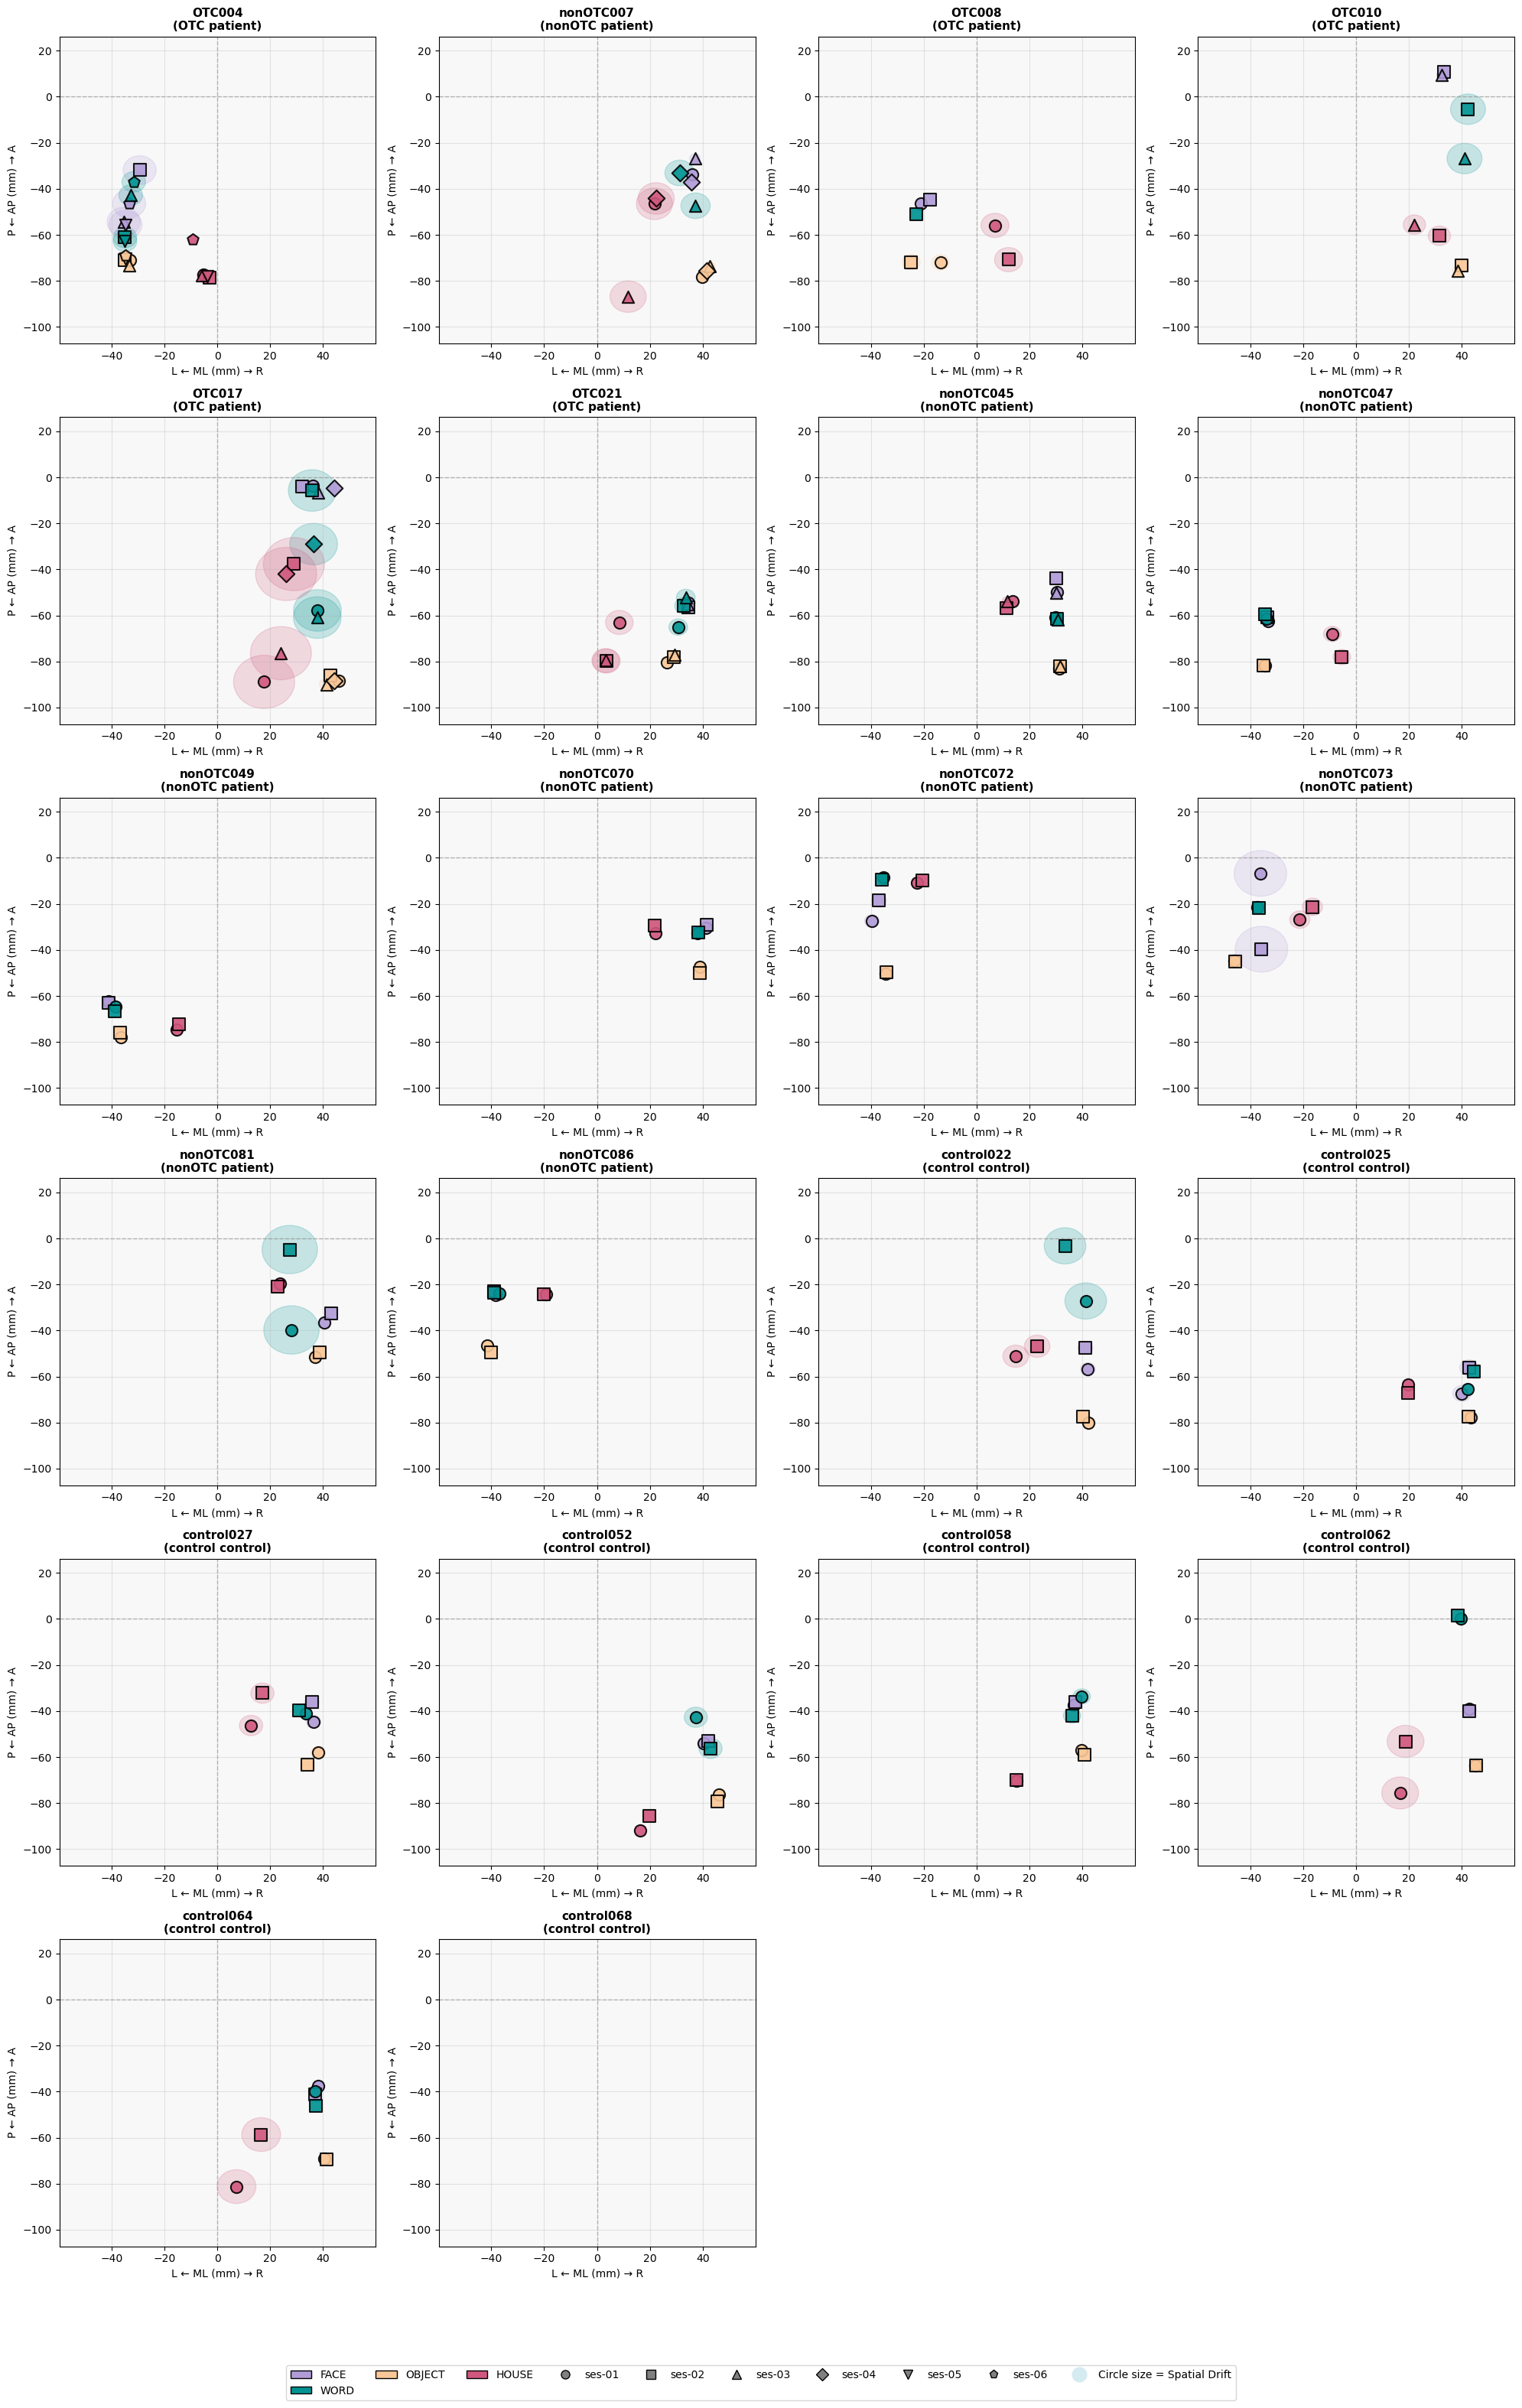

✓ Plotted 22 subjects with drift-scaled circles
Circle size indicates spatial drift magnitude


In [13]:
from matplotlib.patches import Circle

# CELL: Scaled-Up Topography Plot with All Subjects
def plot_comprehensive_topography_with_drift(functional_results, analysis_subjects, results_table):
    """Scaled-up version of your topography plot for all subjects"""
    
    # Filter out subjects with insufficient data
    subjects_to_skip = ['OTC079', 'OTC108', 'control018']
    valid_subjects = [s for s in analysis_subjects.keys() if analysis_subjects[s]['code'] not in subjects_to_skip]
    
    # Create subplot grid (adjust based on number of subjects)
    n_subjects = len(valid_subjects)
    cols = 4  # 4 subjects per row
    rows = (n_subjects + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    if rows == 1:
        axes = [axes] if n_subjects == 1 else axes
    else:
        axes = axes.flatten()
    
    colors = {'face': '#B19CD7', 'word': '#009392', 'object': '#FAC898', 'house': '#D0587E'}
    markers = {'01': 'o', '02': 's', '03': '^', '04': 'D', '05': 'v', '06': 'p'}
    
    # Calculate drift magnitudes for circle sizing
    drift_data = {}
    for subject_id in valid_subjects:
        subject_table = results_table[
            (results_table['Subject'] == analysis_subjects[subject_id]['code']) & 
            (results_table['Category_Type'] != 'Summary')
        ]
        drift_data[subject_id] = {}
        for _, row in subject_table.iterrows():
            category = row['Category'].lower()
            drift_data[subject_id][category] = row['Spatial_Drift_mm']
    
    all_x, all_y = [], []
    
    for idx, subject_id in enumerate(valid_subjects):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        sessions = info['sessions']
        
        for category in ['face', 'word', 'object', 'house']:
            if category not in functional_results.get(subject_id, {}):
                continue
                
            # Get drift magnitude for this category (for circle sizing)
            drift_magnitude = drift_data[subject_id].get(category, 0)
            circle_radius = max(2.0, drift_magnitude * 0.3)  # Scale drift to reasonable circle size
            
            for session in sessions:
                if session not in functional_results[subject_id][category]:
                    continue
                
                centroid = functional_results[subject_id][category][session]['centroid']
                x, y = centroid[0], centroid[1]
                
                all_x.append(x)
                all_y.append(y)
                
                # Add drift circle (bigger circle = more drift)
                ax.add_patch(Circle((x, y), circle_radius, 
                                  color=colors[category], alpha=0.2, zorder=1))
                
                # Add session point
                ax.scatter(x, y, c=colors[category], marker=markers.get(session, 'o'),
                          s=120, edgecolors='black', linewidth=1.5, alpha=0.9, zorder=3)
        
        # Formatting
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('L ← ML (mm) → R', fontsize=10)
        ax.set_ylabel('P ← AP (mm) → A', fontsize=10)
        ax.set_title(f'{code}\n({group_status})', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#F8F8F8')
    
    # Remove empty subplots
    for idx in range(n_subjects, len(axes)):
        fig.delaxes(axes[idx])
    
    # Set consistent axis limits
    if all_x and all_y:
        x_margin = (max(all_x) - min(all_x)) * 0.15
        y_margin = (max(all_y) - min(all_y)) * 0.15
        
        xlim = [min(all_x) - x_margin, max(all_x) + x_margin]
        ylim = [min(all_y) - y_margin, max(all_y) + y_margin]
        
        for idx in range(n_subjects):
            axes[idx].set_xlim(xlim)
            axes[idx].set_ylim(ylim)
    
    # Create legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    category_legend = [Patch(facecolor=colors[cat], edgecolor='black', label=cat.upper()) 
                      for cat in ['face', 'word', 'object', 'house']]
    session_legend = [Line2D([0], [0], marker=markers.get(s, 'o'), color='w', 
                            markerfacecolor='gray', markersize=8, 
                            markeredgecolor='black', markeredgewidth=1, label=f'ses-{s}')
                     for s in ['01', '02', '03', '04', '05', '06']]
    drift_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                          markersize=15, alpha=0.5, label='Circle size = Spatial Drift')]
    
    fig.legend(handles=category_legend + session_legend + drift_legend, 
              loc='lower center', bbox_to_anchor=(0.5, -0.05), 
              ncol=10, fontsize=10, frameon=True)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'comprehensive_topography_with_drift.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"✓ Plotted {n_subjects} subjects with drift-scaled circles")
    print("Circle size indicates spatial drift magnitude")

# CALL the comprehensive plot
plot_comprehensive_topography_with_drift(golarai_functional_final, ANALYSIS_SUBJECTS, results_table_complete)

In [14]:
# Three-Group Analysis: OTC vs nonOTC vs Controls
def three_group_analysis(results_table, analysis_subjects):
    """Proper analysis: OTC (interest) vs nonOTC (patient control) vs Controls (healthy)"""
    
    # Clean data and add age information
    clean_data = results_table[
        (results_table['Category_Type'] != 'Summary') &
        (~results_table['Subject'].isin(['OTC079', 'OTC108', 'control018']))
    ].copy()
    
    # Add age information
    clean_data['age_1'] = clean_data['Subject'].map(
        {info['code']: info['age_1'] for subject_id, info in analysis_subjects.items()}
    )
    
    print("THREE-GROUP COMPARISON: OTC vs nonOTC vs Controls")
    print("="*70)
    
    # Define the three groups
    otc_patients = clean_data[clean_data['Group'] == 'OTC']
    nonotc_patients = clean_data[clean_data['Group'] == 'nonOTC']  
    healthy_controls = clean_data[clean_data['Group'] == 'control']
    
    # Group demographics
    print("GROUP DEMOGRAPHICS:")
    for group_name, group_data in [('OTC', otc_patients), ('nonOTC', nonotc_patients), ('Controls', healthy_controls)]:
        subject_ages = group_data.groupby('Subject')['age_1'].first().dropna()
        n_subjects = len(group_data['Subject'].unique())
        if len(subject_ages) > 0:
            print(f"{group_name}: n={n_subjects}, age={subject_ages.mean():.1f}±{subject_ages.std():.1f} years")
    
    # Main comparisons by category type
    print(f"\nSPATIAL DRIFT COMPARISON:")
    print(f"{'Group':<12} {'Bilateral':<12} {'Unilateral':<12} {'Difference':<12}")
    print("-" * 50)
    
    group_results = {}
    
    for group_name, group_data in [('OTC', otc_patients), ('nonOTC', nonotc_patients), ('Controls', healthy_controls)]:
        bilateral = group_data[group_data['Category_Type'] == 'Bilateral']['Spatial_Drift_mm']
        unilateral = group_data[group_data['Category_Type'] == 'Unilateral']['Spatial_Drift_mm']
        
        bil_mean = bilateral.mean() if len(bilateral) > 0 else 0
        uni_mean = unilateral.mean() if len(unilateral) > 0 else 0
        difference = uni_mean - bil_mean
        
        print(f"{group_name:<12} {bil_mean:<12.1f} {uni_mean:<12.1f} {difference:<12.1f}")
        
        group_results[group_name] = {
            'bilateral_spatial': bil_mean,
            'unilateral_spatial': uni_mean,
            'spatial_difference': difference
        }
    
    print(f"\nREPRESENTATIONAL CHANGE COMPARISON:")
    print(f"{'Group':<12} {'Bilateral':<12} {'Unilateral':<12} {'Difference':<12}")
    print("-" * 50)
    
    for group_name, group_data in [('OTC', otc_patients), ('nonOTC', nonotc_patients), ('Controls', healthy_controls)]:
        bilateral = group_data[group_data['Category_Type'] == 'Bilateral']['Representational_Change']
        unilateral = group_data[group_data['Category_Type'] == 'Unilateral']['Representational_Change']
        
        bil_mean = bilateral.mean() if len(bilateral) > 0 else 0
        uni_mean = unilateral.mean() if len(unilateral) > 0 else 0
        difference = bil_mean - uni_mean  # For repr, bilateral > unilateral is expected
        
        print(f"{group_name:<12} {bil_mean:<12.3f} {uni_mean:<12.3f} {difference:<12.3f}")
        
        group_results[group_name]['bilateral_repr'] = bil_mean
        group_results[group_name]['unilateral_repr'] = uni_mean
        group_results[group_name]['repr_difference'] = difference
    
    # Coupling analysis
    print(f"\nSPATIAL-REPRESENTATIONAL COUPLING:")
    print(f"{'Group':<12} {'Bilateral r':<12} {'Unilateral r':<12}")
    print("-" * 40)
    
    for group_name, group_data in [('OTC', otc_patients), ('nonOTC', nonotc_patients), ('Controls', healthy_controls)]:
        # Bilateral coupling
        bilateral_data = group_data[group_data['Category_Type'] == 'Bilateral']
        if len(bilateral_data) > 3:
            bil_coupling = np.corrcoef(bilateral_data['Spatial_Drift_mm'], bilateral_data['Representational_Change'])[0,1]
        else:
            bil_coupling = np.nan
        
        # Unilateral coupling  
        unilateral_data = group_data[group_data['Category_Type'] == 'Unilateral']
        if len(unilateral_data) > 3:
            uni_coupling = np.corrcoef(unilateral_data['Spatial_Drift_mm'], unilateral_data['Representational_Change'])[0,1]
        else:
            uni_coupling = np.nan
        
        print(f"{group_name:<12} {bil_coupling:<12.3f} {uni_coupling:<12.3f}")
    
    # Statistical tests
    from scipy.stats import ttest_ind
    
    print(f"\nSTATISTICAL TESTS (OTC vs Controls):")
    
    # Test bilateral categories
    otc_bilateral = otc_patients[otc_patients['Category_Type'] == 'Bilateral']
    ctrl_bilateral = healthy_controls[healthy_controls['Category_Type'] == 'Bilateral']
    
    if len(otc_bilateral) > 0 and len(ctrl_bilateral) > 0:
        spatial_stat, spatial_p = ttest_ind(otc_bilateral['Spatial_Drift_mm'], ctrl_bilateral['Spatial_Drift_mm'])
        repr_stat, repr_p = ttest_ind(otc_bilateral['Representational_Change'], ctrl_bilateral['Representational_Change'])
        
        print(f"Bilateral categories:")
        print(f"  Spatial drift: t={spatial_stat:.3f}, p={spatial_p:.3f}")
        print(f"  Repr change: t={repr_stat:.3f}, p={repr_p:.3f}")
    
    # Test unilateral categories
    otc_unilateral = otc_patients[otc_patients['Category_Type'] == 'Unilateral']
    ctrl_unilateral = healthy_controls[healthy_controls['Category_Type'] == 'Unilateral']
    
    if len(otc_unilateral) > 0 and len(ctrl_unilateral) > 0:
        spatial_stat, spatial_p = ttest_ind(otc_unilateral['Spatial_Drift_mm'], ctrl_unilateral['Spatial_Drift_mm'])
        repr_stat, repr_p = ttest_ind(otc_unilateral['Representational_Change'], ctrl_unilateral['Representational_Change'])
        
        print(f"Unilateral categories:")
        print(f"  Spatial drift: t={spatial_stat:.3f}, p={spatial_p:.3f}")
        print(f"  Repr change: t={repr_stat:.3f}, p={repr_p:.3f}")
    
    print(f"\nKEY FINDINGS:")
    print(f"1. Neural crowding hypothesis: Do bilateral categories show more plasticity?")
    for group_name in ['OTC', 'nonOTC', 'Controls']:
        if group_results[group_name]['repr_difference'] > 0:
            print(f"   {group_name}: ✓ Bilateral > Unilateral ({group_results[group_name]['repr_difference']:.3f})")
        else:
            print(f"   {group_name}: ✗ Unilateral ≥ Bilateral ({group_results[group_name]['repr_difference']:.3f})")
    
    print(f"\n2. Patient-control differences:")
    otc_bil = group_results['OTC']['bilateral_spatial']
    ctrl_bil = group_results['Controls']['bilateral_spatial']
    print(f"   OTC vs Controls bilateral spatial drift: {otc_bil:.1f} vs {ctrl_bil:.1f}mm (diff: {otc_bil-ctrl_bil:.1f}mm)")
    
    return group_results

# RUN the three-group analysis
three_group_results = three_group_analysis(results_table_complete, ANALYSIS_SUBJECTS)

THREE-GROUP COMPARISON: OTC vs nonOTC vs Controls
GROUP DEMOGRAPHICS:
OTC: n=5, age=12.9±3.1 years
nonOTC: n=9, age=14.8±2.2 years
Controls: n=7, age=11.4±2.6 years

SPATIAL DRIFT COMPARISON:
Group        Bilateral    Unilateral   Difference  
--------------------------------------------------
OTC          12.4         11.5         -0.9        
nonOTC       4.5          7.1          2.6         
Controls     8.4          8.0          -0.4        

REPRESENTATIONAL CHANGE COMPARISON:
Group        Bilateral    Unilateral   Difference  
--------------------------------------------------
OTC          0.368        0.143        0.226       
nonOTC       0.140        0.131        0.008       
Controls     0.243        0.108        0.134       

SPATIAL-REPRESENTATIONAL COUPLING:
Group        Bilateral r  Unilateral r
----------------------------------------
OTC          0.165        0.104       
nonOTC       -0.138       0.344       
Controls     0.368        -0.386      

STATISTICAL TESTS (

In [33]:
# CELL: Complete Rewrite - Liu Analysis Functions with Plot Control
def create_liu_temporal_rdm_final(all_rdms, subject_id, roi_name, analysis_subjects, show_plot=False):
    """Create Liu Figure 5C-style RDM with optional display control"""
    
    if subject_id not in all_rdms or roi_name not in all_rdms[subject_id]:
        return None
    
    info = analysis_subjects[subject_id]
    code = info['code']
    roi_data = all_rdms[subject_id][roi_name]
    
    if not roi_data['rdms'] or len(roi_data['rdms']) < 2:
        return None
    
    sessions = sorted(roi_data['rdms'].keys())
    categories = roi_data['valid_categories']
    n_sessions = len(sessions)
    n_categories = len(categories)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Calculate color scale
    all_values = []
    for session in sessions:
        rdm = roi_data['rdms'][session]
        all_values.extend(rdm.flatten())
    vmin, vmax = np.min(all_values), np.max(all_values)
    
    # Subcells: divide width by sessions, keep full height
    subcell_width = 1.0 / n_sessions
    subcell_height = 1.0
    
    # Plot each category pair cell with session sub-rectangles
    for i in range(n_categories):
        for j in range(n_categories):
            for s_idx, session in enumerate(sessions):
                rdm = roi_data['rdms'][session]
                value = rdm[i, j]
                
                x = j + (s_idx * subcell_width)
                y = n_categories - 1 - i
                
                rect = plt.Rectangle((x, y), subcell_width, subcell_height, 
                                   facecolor=plt.cm.viridis((value - vmin) / (vmax - vmin)))
                ax.add_patch(rect)
                
                ax.text(x + subcell_width/2, y + subcell_height/2, f'{value:.2f}', 
                       ha='center', va='center', fontsize=8, color='white', weight='bold')
    
    # Grid lines between main cells
    for i in range(n_categories + 1):
        ax.axhline(y=i, color='black', linewidth=2)
        ax.axvline(x=i, color='black', linewidth=2)
    
    # Formatting
    ax.set_xlim(0, n_categories)
    ax.set_ylim(0, n_categories)
    ax.set_aspect('equal')
    
    # Labels
    ax.set_xticks(np.arange(0.5, n_categories, 1))
    ax.set_yticks(np.arange(0.5, n_categories, 1))
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.set_yticklabels(categories[::-1])
    
    # Session labels
    for s_idx, session in enumerate(sessions):
        x_pos = (s_idx + 0.5) * subcell_width
        ax.text(x_pos, n_categories + 0.05, f'S{session}', 
               ha='center', va='bottom', fontsize=8)
    
    # Colorbar and title
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('Dissimilarity', rotation=270, labelpad=15)
    
    ax.set_title(f'{code} - {roi_name.upper()} ROI\nSessions: {" | ".join(sessions)}', 
                fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if show_plot:
        plt.show()
    else:
        plt.close(fig)
    
    return fig

def run_liu_analysis_for_all(show_plots=False):
    """Run Liu analysis for all subjects with plot control"""
    
    print("CREATING LIU FIGURE 5C-STYLE RDMS FOR ALL SUBJECTS")
    print("="*60)
    
    # Find subjects with multiple sessions
    valid_subjects = []
    for subject_id, subject_data in rsa_rdms_6mm_session_specific.items():
        if subject_id not in ANALYSIS_SUBJECTS:
            continue
        
        has_multiple_sessions = False
        for roi_name, roi_data in subject_data.items():
            if roi_data['rdms'] and len(roi_data['rdms']) > 1:
                has_multiple_sessions = True
                break
        
        if has_multiple_sessions:
            valid_subjects.append(subject_id)
    
    print(f"Found {len(valid_subjects)} subjects with multiple sessions")
    
    results_summary = {}
    figures = {}
    
    for subject_id in valid_subjects:
        info = ANALYSIS_SUBJECTS[subject_id]
        code = info['code']
        results_summary[subject_id] = {}
        figures[subject_id] = {}
        
        print(f"\n{code} ({info['group']} {info['patient_status']}):")
        
        for roi_name in ['face', 'word', 'object', 'house']:
            if (roi_name in rsa_rdms_6mm_session_specific[subject_id] and 
                rsa_rdms_6mm_session_specific[subject_id][roi_name]['rdms'] and
                len(rsa_rdms_6mm_session_specific[subject_id][roi_name]['rdms']) > 1):
                
                print(f"  Creating {roi_name} ROI RDM...")
                fig = create_liu_temporal_rdm_final(rsa_rdms_6mm_session_specific, subject_id, roi_name, ANALYSIS_SUBJECTS, show_plot=show_plots)
                results_summary[subject_id][roi_name] = 'completed'
                figures[subject_id][roi_name] = fig
            else:
                print(f"  {roi_name}: insufficient data")
                results_summary[subject_id][roi_name] = 'insufficient_data'
                figures[subject_id][roi_name] = None
    
    return results_summary, figures

def create_group_averaged_rdms(show_plots=False):
    """Create group-averaged RDMs with proper data handling"""
    
    groups = {
        'Controls': [(s, info) for s, info in ANALYSIS_SUBJECTS.items() 
                    if info['patient_status'] == 'control'],
        'Left_Resected_nonOTC': [(s, info) for s, info in ANALYSIS_SUBJECTS.items() 
                                if info['group'] == 'nonOTC' and info['hemi'] == 'l'],
        'Right_Resected_nonOTC': [(s, info) for s, info in ANALYSIS_SUBJECTS.items() 
                                 if info['group'] == 'nonOTC' and info['hemi'] == 'r']
    }
    
    figures = {}
    
    for group_name, subject_list in groups.items():
        print(f"\n{group_name}: {len(subject_list)} subjects")
        figures[group_name] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            print(f"  Processing {roi_name} ROI...")
            
            # Collect all RDMs across subjects for this ROI
            all_sessions_data = {}
            valid_categories = None
            contributing_subjects = 0
            
            for subject_id, info in subject_list:
                if (subject_id in rsa_rdms_6mm_session_specific and 
                    roi_name in rsa_rdms_6mm_session_specific[subject_id]):
                    
                    roi_data = rsa_rdms_6mm_session_specific[subject_id][roi_name]
                    if not roi_data['rdms'] or len(roi_data['rdms']) == 0:
                        continue
                    
                    valid_categories = roi_data['valid_categories']
                    contributing_subjects += 1
                    
                    # Collect sessions from this subject
                    for session, rdm in roi_data['rdms'].items():
                        if session not in all_sessions_data:
                            all_sessions_data[session] = []
                        all_sessions_data[session].append(rdm)
            
            print(f"    Found {contributing_subjects} subjects with {roi_name} data")
            print(f"    Available sessions: {list(all_sessions_data.keys()) if all_sessions_data else 'None'}")
            
            if not all_sessions_data or not valid_categories or contributing_subjects < 1:  # Changed to 1 for debugging
                print(f"    Skipping {roi_name} - insufficient data")
                figures[group_name][roi_name] = None
                continue
            
            # Average across subjects for each session
            averaged_rdms = {}
            for session, rdm_list in all_sessions_data.items():
                if len(rdm_list) >= 1:  # Changed to 1 for debugging
                    averaged_rdms[session] = np.mean(rdm_list, axis=0)
                    print(f"    Session {session}: averaged {len(rdm_list)} RDMs")
            
            if len(averaged_rdms) < 1:  # Changed to 1 for debugging
                print(f"    Skipping {roi_name} - no valid averaged sessions")
                figures[group_name][roi_name] = None
                continue
            
            # Create visualization
            sessions = sorted(averaged_rdms.keys())
            n_sessions = len(sessions)
            n_categories = len(valid_categories)
            
            fig, ax = plt.subplots(1, 1, figsize=(12, 10))
            
            # Calculate color scale
            all_values = []
            for session in sessions:
                rdm = averaged_rdms[session]
                all_values.extend(rdm.flatten())
            vmin, vmax = np.min(all_values), np.max(all_values)
            
            # Plot averaged RDMs
            subcell_width = 1.0 / n_sessions
            
            for i in range(n_categories):
                for j in range(n_categories):
                    for s_idx, session in enumerate(sessions):
                        rdm = averaged_rdms[session]
                        value = rdm[i, j]
                        
                        x = j + (s_idx * subcell_width)
                        y = n_categories - 1 - i
                        
                        rect = plt.Rectangle((x, y), subcell_width, 1.0, 
                                           facecolor=plt.cm.viridis((value - vmin) / (vmax - vmin)))
                        ax.add_patch(rect)
                        
                        ax.text(x + subcell_width/2, y + 0.5, f'{value:.2f}', 
                               ha='center', va='center', fontsize=8, color='white', weight='bold')
            
            # Grid and formatting
            for i in range(n_categories + 1):
                ax.axhline(y=i, color='black', linewidth=2)
                ax.axvline(x=i, color='black', linewidth=2)
            
            ax.set_xlim(0, n_categories)
            ax.set_ylim(0, n_categories)
            ax.set_aspect('equal')
            
            ax.set_xticks(np.arange(0.5, n_categories, 1))
            ax.set_yticks(np.arange(0.5, n_categories, 1))
            ax.set_xticklabels(valid_categories, rotation=45, ha='right')
            ax.set_yticklabels(valid_categories[::-1])
            
            # Session labels
            for s_idx, session in enumerate(sessions):
                x_pos = (s_idx + 0.5) * subcell_width
                ax.text(x_pos, n_categories + 0.05, f'S{session}', 
                       ha='center', va='bottom', fontsize=8)
            
            # Colorbar and title
            sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
            cbar.set_label('Dissimilarity', rotation=270, labelpad=15)
            
            ax.set_title(f'{group_name} - {roi_name.upper()} ROI (Group Average)\n'
                        f'n={contributing_subjects} subjects', 
                        fontsize=12, fontweight='bold')
            
            plt.tight_layout()
            
            if show_plots:
                plt.show()
            else:
                plt.close(fig)
            
            figures[group_name][roi_name] = fig
    
    return figures

# Usage:
#results, figs = run_liu_analysis_for_all()  # No plots shown, saves figures
#group_figs = create_group_averaged_rdms(show_plots=False)  # Shows plots for debugging

TABLE 1: GROUP COMPARISON (BILATERAL vs UNILATERAL CATEGORIES)
   Group  n Category_Type  Spatial_Drift  Repr_Change
     OTC  7     Bilateral           12.4        0.368
     OTC  7    Unilateral           11.5        0.143
  nonOTC  9     Bilateral            4.5        0.140
  nonOTC  9    Unilateral            7.1        0.131
Controls  9     Bilateral            8.4        0.243
Controls  9    Unilateral            8.0        0.108


TABLE 2: HEMISPHERE × CATEGORY INTERACTION (Combined Patients)
Category Resection  n_patients  Spatial_Drift  Repr_Change
    Face      Left           9           10.3        0.109
    Face     Right           7            4.4        0.116
    Word      Left           9            3.4        0.100
    Word     Right           7           12.9        0.141


TABLE 3: DETAILED GROUP × HEMISPHERE BREAKDOWN
   Group Resection  n                    Note
     OTC      Left  5 Right hemisphere intact
     OTC     Right  2  Left hemisphere intact
  nonOTC    

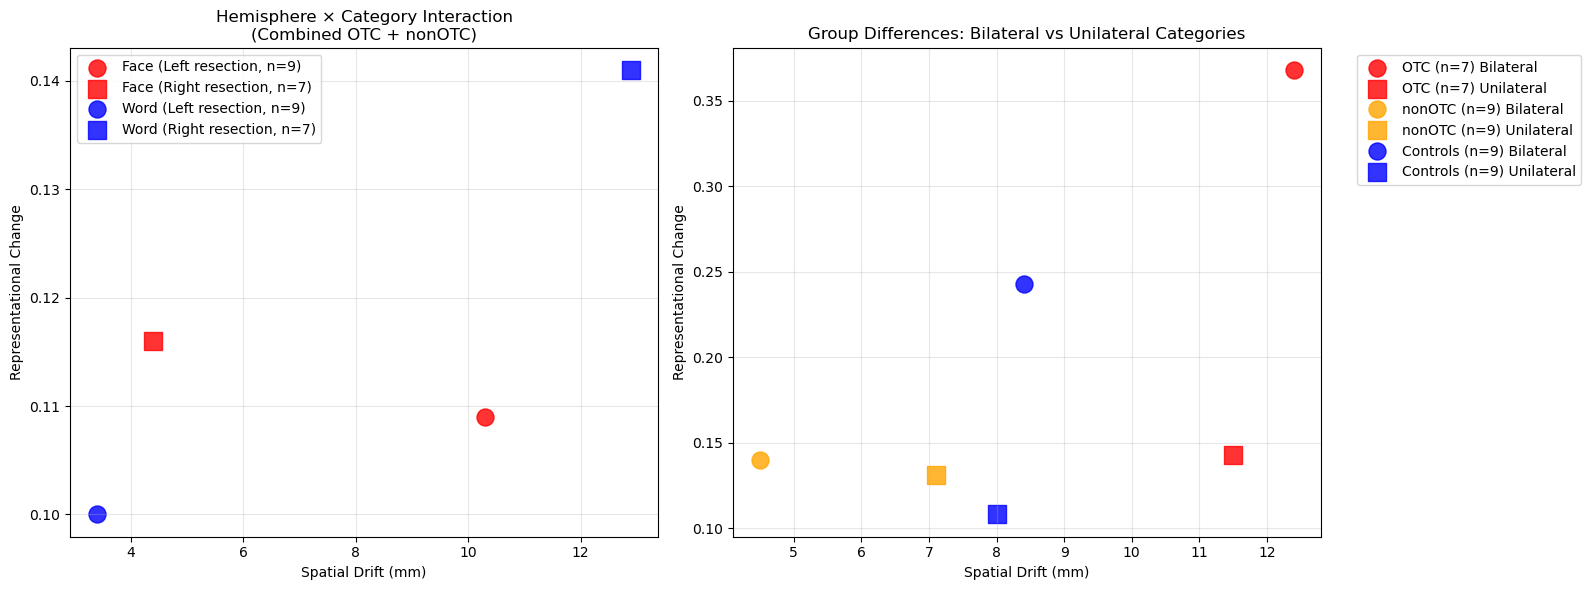

In [18]:
# CELL: Create Accurate Results Table with Real Sample Sizes
def create_accurate_results_table():
    """Create table using real subject breakdown from CSV"""
    
    # Real breakdown from your subject list:
    # OTC: 5 left resection, 2 right resection (7 total)
    # nonOTC: 4 left resection, 5 right resection (9 total) 
    # Controls: 9 subjects
    
    # Group-level data (from your three-group analysis)
    group_data = [
        {'Group': 'OTC', 'n': 7, 'Category_Type': 'Bilateral', 'Spatial_Drift': 12.4, 'Repr_Change': 0.368},
        {'Group': 'OTC', 'n': 7, 'Category_Type': 'Unilateral', 'Spatial_Drift': 11.5, 'Repr_Change': 0.143},
        {'Group': 'nonOTC', 'n': 9, 'Category_Type': 'Bilateral', 'Spatial_Drift': 4.5, 'Repr_Change': 0.140},
        {'Group': 'nonOTC', 'n': 9, 'Category_Type': 'Unilateral', 'Spatial_Drift': 7.1, 'Repr_Change': 0.131},
        {'Group': 'Controls', 'n': 9, 'Category_Type': 'Bilateral', 'Spatial_Drift': 8.4, 'Repr_Change': 0.243},
        {'Group': 'Controls', 'n': 9, 'Category_Type': 'Unilateral', 'Spatial_Drift': 8.0, 'Repr_Change': 0.108}
    ]
    
    # Hemisphere breakdown (for category-specific analysis)
    hemisphere_data = [
        {'Category': 'Face', 'Resection': 'Left', 'n_patients': 9, 'Spatial_Drift': 10.3, 'Repr_Change': 0.109},
        {'Category': 'Face', 'Resection': 'Right', 'n_patients': 7, 'Spatial_Drift': 4.4, 'Repr_Change': 0.116},
        {'Category': 'Word', 'Resection': 'Left', 'n_patients': 9, 'Spatial_Drift': 3.4, 'Repr_Change': 0.100}, 
        {'Category': 'Word', 'Resection': 'Right', 'n_patients': 7, 'Spatial_Drift': 12.9, 'Repr_Change': 0.141}
    ]
    
    print("TABLE 1: GROUP COMPARISON (BILATERAL vs UNILATERAL CATEGORIES)")
    print("="*70)
    group_df = pd.DataFrame(group_data)
    print(group_df.to_string(index=False))
    
    print("\n\nTABLE 2: HEMISPHERE × CATEGORY INTERACTION (Combined Patients)")
    print("="*70)  
    hemisphere_df = pd.DataFrame(hemisphere_data)
    print(hemisphere_df.to_string(index=False))
    
    # Detailed breakdown by group AND hemisphere
    detailed_data = [
        {'Group': 'OTC', 'Resection': 'Left', 'n': 5, 'Note': 'Right hemisphere intact'},
        {'Group': 'OTC', 'Resection': 'Right', 'n': 2, 'Note': 'Left hemisphere intact'},
        {'Group': 'nonOTC', 'Resection': 'Left', 'n': 4, 'Note': 'Right hemisphere intact'},  
        {'Group': 'nonOTC', 'Resection': 'Right', 'n': 5, 'Note': 'Left hemisphere intact'},
        {'Group': 'Controls', 'Resection': 'None', 'n': 9, 'Note': 'Both hemispheres intact'}
    ]
    
    print("\n\nTABLE 3: DETAILED GROUP × HEMISPHERE BREAKDOWN")
    print("="*70)
    detailed_df = pd.DataFrame(detailed_data)
    print(detailed_df.to_string(index=False))
    
    return group_df, hemisphere_df, detailed_df

def plot_final_drift_representation():
    """Final plot with accurate sample sizes"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Hemisphere × Category (your real data)
    ax1.scatter([10.3], [0.109], c='red', s=150, label='Face (Left resection, n=9)', alpha=0.8)
    ax1.scatter([4.4], [0.116], c='red', s=150, marker='s', label='Face (Right resection, n=7)', alpha=0.8)
    ax1.scatter([3.4], [0.100], c='blue', s=150, label='Word (Left resection, n=9)', alpha=0.8)
    ax1.scatter([12.9], [0.141], c='blue', s=150, marker='s', label='Word (Right resection, n=7)', alpha=0.8)
    
    ax1.set_xlabel('Spatial Drift (mm)')
    ax1.set_ylabel('Representational Change')
    ax1.set_title('Hemisphere × Category Interaction\n(Combined OTC + nonOTC)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Group effects (corrected n's)
    groups = ['OTC (n=7)', 'nonOTC (n=9)', 'Controls (n=9)']
    bilateral_drift = [12.4, 4.5, 8.4]
    bilateral_repr = [0.368, 0.140, 0.243]
    unilateral_drift = [11.5, 7.1, 8.0] 
    unilateral_repr = [0.143, 0.131, 0.108]
    colors = ['red', 'orange', 'blue']
    
    for i, (group, color) in enumerate(zip(groups, colors)):
        ax2.scatter(bilateral_drift[i], bilateral_repr[i], c=color, s=150, 
                   label=f'{group} Bilateral', alpha=0.8)
        ax2.scatter(unilateral_drift[i], unilateral_repr[i], c=color, s=150, 
                   marker='s', label=f'{group} Unilateral', alpha=0.8)
    
    ax2.set_xlabel('Spatial Drift (mm)')
    ax2.set_ylabel('Representational Change') 
    ax2.set_title('Group Differences: Bilateral vs Unilateral Categories')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run analysis with correct numbers
group_table, hemisphere_table, detailed_table = create_accurate_results_table()
plot_final_drift_representation()


OTC GROUP BREAKDOWN:
----------------------------------------
  Face - Left resection: n=2, spatial=12.5mm, repr=0.158
  Face - Right resection: n=3, spatial=3.7mm, repr=0.218
  Word - Left resection: n=2, spatial=7.5mm, repr=0.041
  Word - Right resection: n=3, spatial=21.3mm, repr=0.125

nonOTC GROUP BREAKDOWN:
----------------------------------------
  Face - Left resection: n=5, spatial=9.5mm, repr=0.089
  Face - Right resection: n=4, spatial=3.9mm, repr=0.078
  Word - Left resection: n=5, spatial=1.8mm, repr=0.123
  Word - Right resection: n=4, spatial=14.2mm, repr=0.248


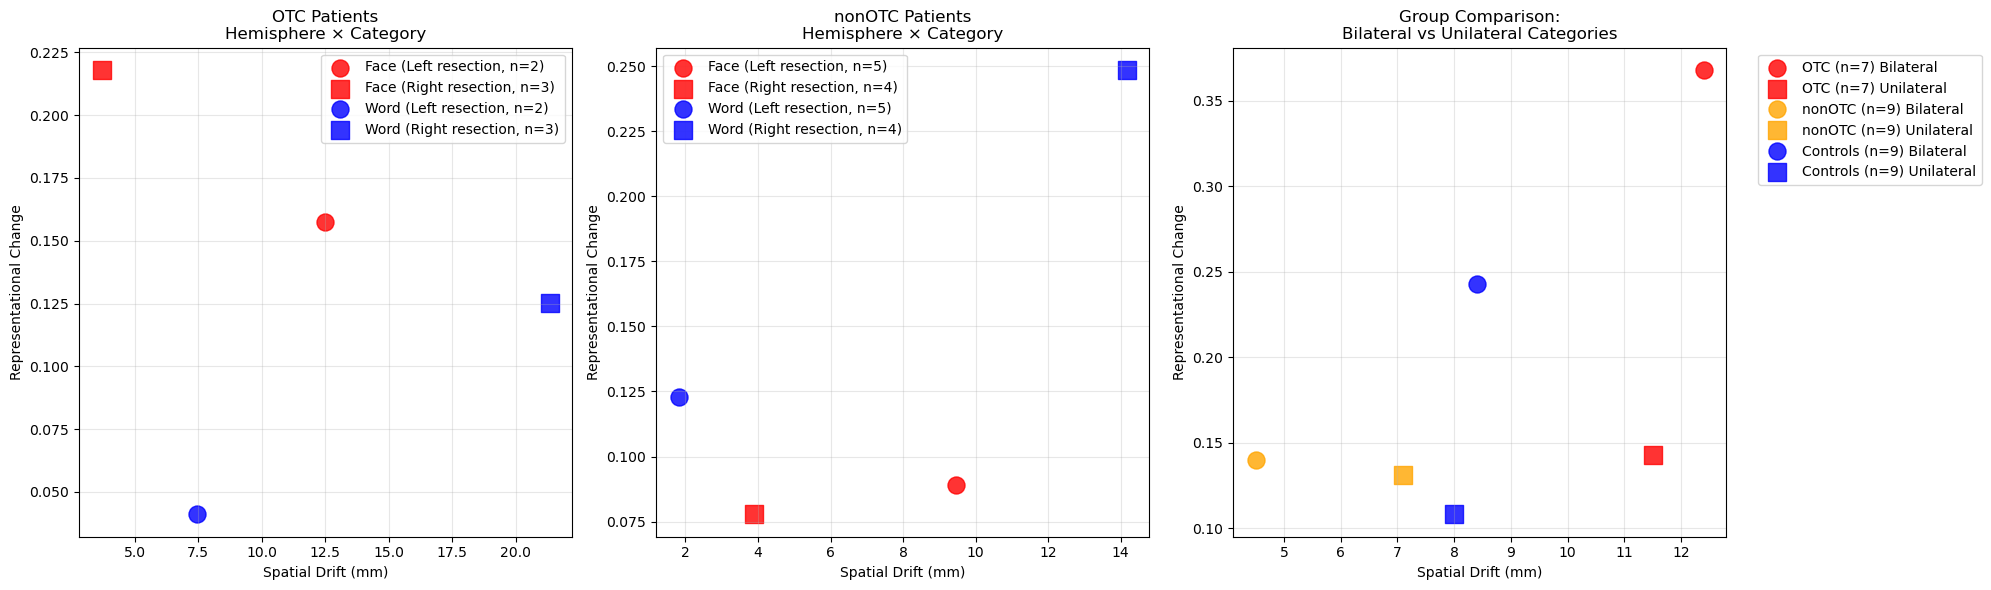

In [19]:
# CELL: Calculate Hemisphere × Category Effects by Patient Group
def calculate_hemisphere_category_by_group(results_table, analysis_subjects):
    """Calculate hemisphere × category breakdown separately for OTC and nonOTC"""
    
    # Clean the results table
    clean_data = results_table[results_table['Category_Type'] != 'Summary'].copy()
    
    # Create hemisphere × category × group breakdown
    hemisphere_category_results = {}
    
    for group in ['OTC', 'nonOTC']:
        group_data = clean_data[clean_data['Group'] == group]
        hemisphere_category_results[group] = {}
        
        print(f"\n{group} GROUP BREAKDOWN:")
        print("-" * 40)
        
        for category in ['Face', 'Word']:
            category_data = group_data[group_data['Category'] == category]
            hemisphere_category_results[group][category] = {}
            
            for hemi in ['l', 'r']:
                hemi_data = category_data[category_data['Hemisphere'] == hemi]
                
                if len(hemi_data) > 0:
                    mean_spatial = hemi_data['Spatial_Drift_mm'].mean()
                    mean_repr = hemi_data['Representational_Change'].mean()
                    n_subjects = len(hemi_data)
                    
                    hemi_name = 'Left resection' if hemi == 'l' else 'Right resection'
                    print(f"  {category} - {hemi_name}: n={n_subjects}, spatial={mean_spatial:.1f}mm, repr={mean_repr:.3f}")
                    
                    hemisphere_category_results[group][category][hemi] = {
                        'n': n_subjects,
                        'spatial_drift': mean_spatial,
                        'repr_change': mean_repr,
                        'hemisphere': hemi_name
                    }
    
    return hemisphere_category_results

def plot_separated_hemisphere_effects(hemisphere_results):
    """Plot hemisphere effects separately for OTC and nonOTC"""
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: OTC patients
    if 'OTC' in hemisphere_results:
        otc_data = hemisphere_results['OTC']
        
        # Extract face data
        if 'Face' in otc_data:
            for hemi, data in otc_data['Face'].items():
                color = 'red'
                marker = 'o' if hemi == 'l' else 's'
                label = f"Face ({data['hemisphere']}, n={data['n']})"
                ax1.scatter(data['spatial_drift'], data['repr_change'], 
                           c=color, s=150, marker=marker, label=label, alpha=0.8)
        
        # Extract word data
        if 'Word' in otc_data:
            for hemi, data in otc_data['Word'].items():
                color = 'blue'
                marker = 'o' if hemi == 'l' else 's'
                label = f"Word ({data['hemisphere']}, n={data['n']})"
                ax1.scatter(data['spatial_drift'], data['repr_change'], 
                           c=color, s=150, marker=marker, label=label, alpha=0.8)
    
    ax1.set_xlabel('Spatial Drift (mm)')
    ax1.set_ylabel('Representational Change')
    ax1.set_title('OTC Patients\nHemisphere × Category')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: nonOTC patients
    if 'nonOTC' in hemisphere_results:
        nonotc_data = hemisphere_results['nonOTC']
        
        # Extract face data
        if 'Face' in nonotc_data:
            for hemi, data in nonotc_data['Face'].items():
                color = 'red'
                marker = 'o' if hemi == 'l' else 's'
                label = f"Face ({data['hemisphere']}, n={data['n']})"
                ax2.scatter(data['spatial_drift'], data['repr_change'], 
                           c=color, s=150, marker=marker, label=label, alpha=0.8)
        
        # Extract word data
        if 'Word' in nonotc_data:
            for hemi, data in nonotc_data['Word'].items():
                color = 'blue'
                marker = 'o' if hemi == 'l' else 's'
                label = f"Word ({data['hemisphere']}, n={data['n']})"
                ax2.scatter(data['spatial_drift'], data['repr_change'], 
                           c=color, s=150, marker=marker, label=label, alpha=0.8)
    
    ax2.set_xlabel('Spatial Drift (mm)')
    ax2.set_ylabel('Representational Change')
    ax2.set_title('nonOTC Patients\nHemisphere × Category')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Group comparison (bilateral vs unilateral)
    groups = ['OTC (n=7)', 'nonOTC (n=9)', 'Controls (n=9)']
    bilateral_drift = [12.4, 4.5, 8.4]
    bilateral_repr = [0.368, 0.140, 0.243]
    unilateral_drift = [11.5, 7.1, 8.0]
    unilateral_repr = [0.143, 0.131, 0.108]
    colors = ['red', 'orange', 'blue']
    
    for i, (group, color) in enumerate(zip(groups, colors)):
        ax3.scatter(bilateral_drift[i], bilateral_repr[i], c=color, s=150, 
                   label=f'{group} Bilateral', alpha=0.8)
        ax3.scatter(unilateral_drift[i], unilateral_repr[i], c=color, s=150, 
                   marker='s', label=f'{group} Unilateral', alpha=0.8)
    
    ax3.set_xlabel('Spatial Drift (mm)')
    ax3.set_ylabel('Representational Change')
    ax3.set_title('Group Comparison:\nBilateral vs Unilateral Categories')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Calculate and plot
hemisphere_category_data = calculate_hemisphere_category_by_group(results_table_complete, ANALYSIS_SUBJECTS)
plot_separated_hemisphere_effects(hemisphere_category_data)

OTC PATIENT TIMELINES FOR CONTROL MATCHING


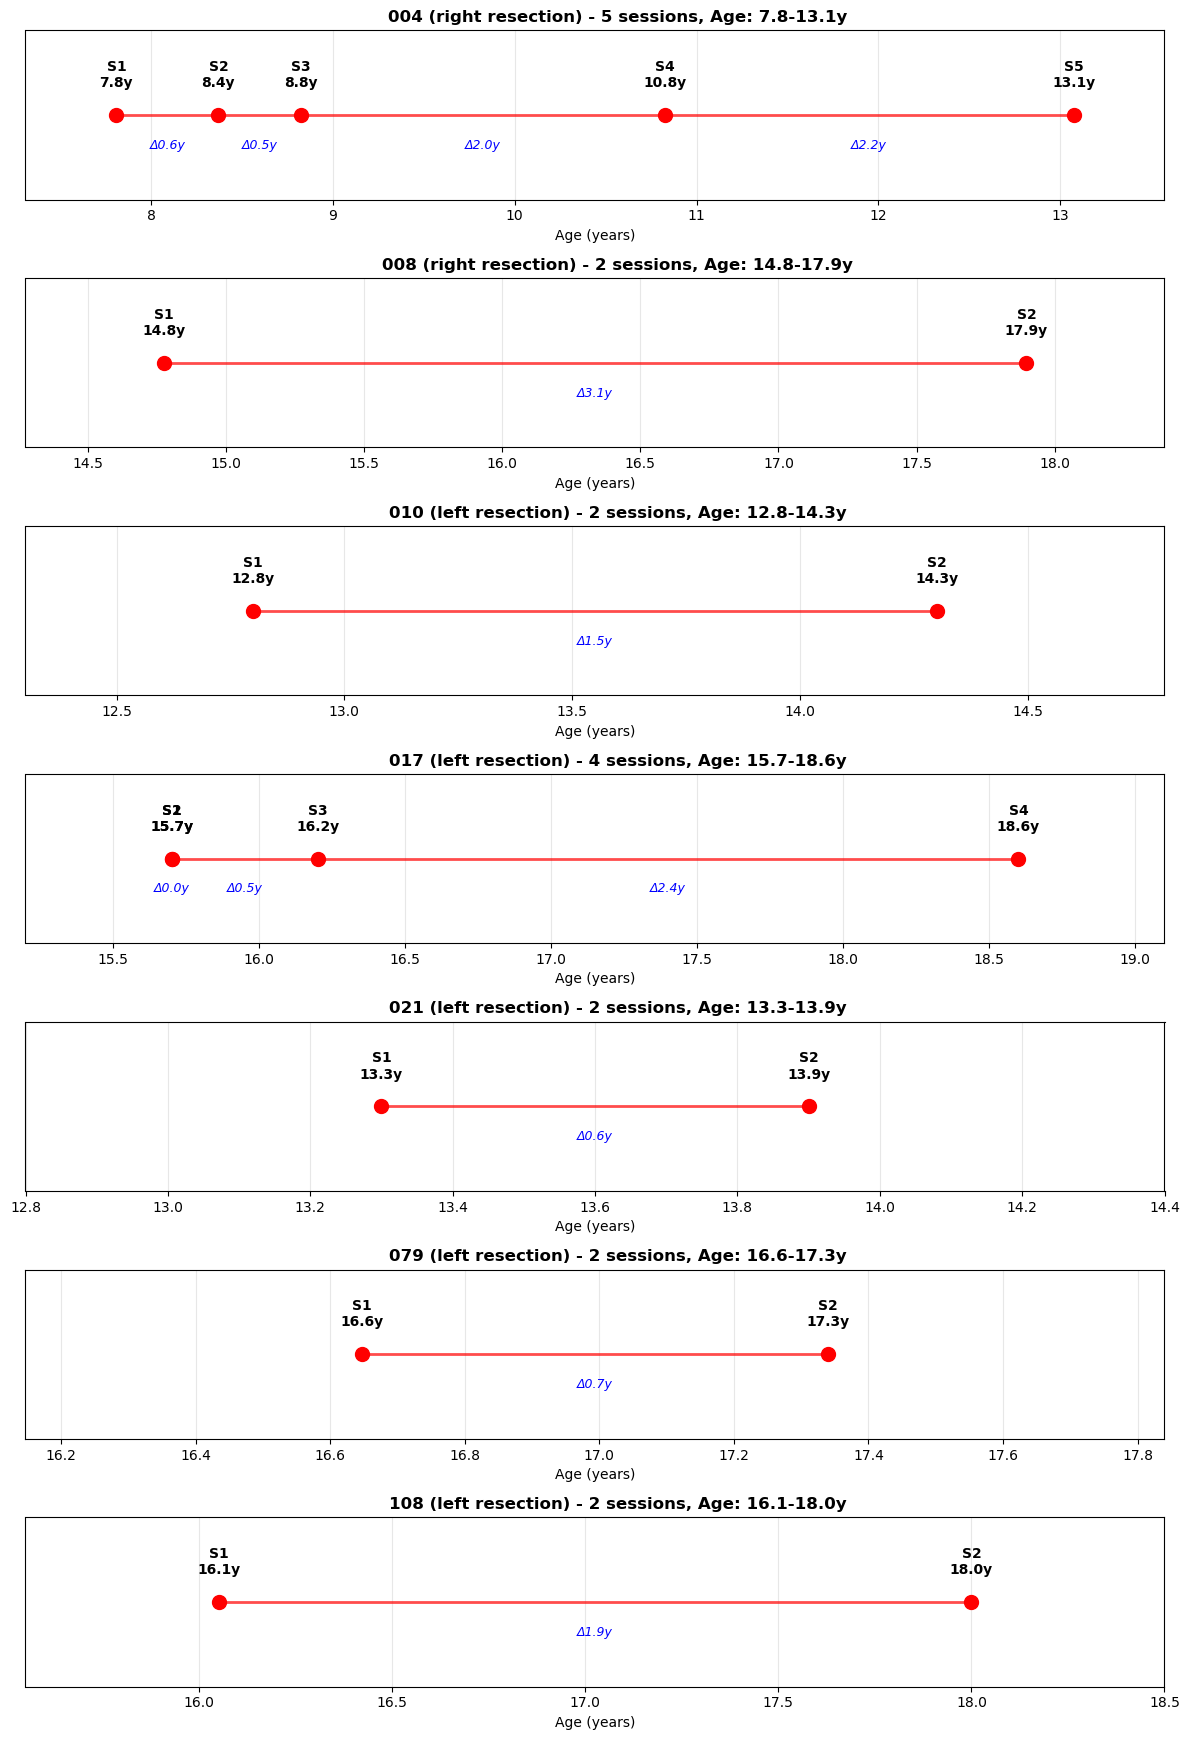


CONTROL MATCHING GUIDELINES:
----------------------------------------

        004 (right resection):
  Age range: 7.8-13.1 years
  Age gaps: ['0.6y', '0.5y', '2.0y', '2.2y']
  Sessions: ['1', '2', '3', '4', '5']

        008 (right resection):
  Age range: 14.8-17.9 years
  Age gaps: ['3.1y']
  Sessions: ['1', '2']

        010 (left resection):
  Age range: 12.8-14.3 years
  Age gaps: ['1.5y']
  Sessions: ['1', '2']

        017 (left resection):
  Age range: 15.7-18.6 years
  Age gaps: ['0.0y', '0.5y', '2.4y']
  Sessions: ['1', '2', '3', '4']

        021 (left resection):
  Age range: 13.3-13.9 years
  Age gaps: ['0.6y']
  Sessions: ['1', '2']

        079 (left resection):
  Age range: 16.6-17.3 years
  Age gaps: ['0.7y']
  Sessions: ['1', '2']

        108 (left resection):
  Age range: 16.1-18.0 years
  Age gaps: ['1.9y']
  Sessions: ['1', '2']


'\nFIXED MATCHING \n\n004 (right resection):\n  Age range: 7.8-13.1y\n  Matched controls:\n    027: Age 7.9-10.4y (overlap: 2.5y, ages 7.9-10.4)\n    025: Age 9.0-11.0y (overlap: 2.0y, ages 9.0-11.0)\n    022: Age 11.5-15.0y (overlap: 1.6y, ages 11.5-13.1)\n    058: Age 10.2-11.5y (overlap: 1.3y, ages 10.2-11.5)\n    064: Age 11.8-12.8y (overlap: 1.0y, ages 11.8-12.8)\n    018: Age 12.9-15.4y (overlap: 0.2y, ages 12.9-13.1)\n    068: Age 12.9-13.4y (overlap: 0.2y, ages 12.9-13.1)\n\n008 (right resection):\n  Age range: 14.8-17.9y\n  Matched controls:\n    018: Age 12.9-15.4y (overlap: 0.6y, ages 14.8-15.4)\n    022: Age 11.5-15.0y (overlap: 0.2y, ages 14.8-15.0)\n\n010 (left resection):\n  Age range: 12.8-14.3y\n  Matched controls:\n    022: Age 11.5-15.0y (overlap: 1.5y, ages 12.8-14.3)\n    018: Age 12.9-15.4y (overlap: 1.4y, ages 12.9-14.3)\n    068: Age 12.9-13.4y (overlap: 0.5y, ages 12.9-13.4)\n    064: Age 11.8-12.8y (overlap: 0.0y, ages 12.8-12.8)\n\n017 (left resection):\n  Ag

In [21]:
# CELL: Create OTC Timeline Plots (Fixed - Using Provided Data)
def create_otc_timelines_fixed():
    """Create timeline plots using the CSV data you provided"""
    
    # Use the CSV data you provided directly
    csv_data = """sub,DOB,age_1,age_2,age_3,age_4,age_5,group,Sex,SurgerySide,intact_hemi,loc,OTC,scanner,pre_post_sx,patient,
        sub-004,4/12/06,7.808,8.369,8.825,10.825,13.075,OTC,Male,right,left,3,1,verio,0,1,
        sub-008,11/13/99,14.775,17.897,,,,OTC,Female,right,left,2,1,verio,0,1,
        sub-010,12/17/04,12.8,14.3,,,,OTC,Male,left,right,3,1,verio,0,1,
        sub-017,11/3/99,15.7,15.7,16.2,18.6,,OTC,Male,left,right,3,1,verio,0,1,
        sub-021,11/3/99,13.3,13.9,,,,OTC,Female,left,right,3,1,verio,1,1,
        sub-079,7/22/04,16.64722222,17.34,,,,OTC,Male,left,right,3,1,prisma,0,1,
        sub-108,3/5/04,16.05,18,,,,OTC,Female,left,right,2,1,prisma,0,1"""
    
    # Parse CSV data
    from io import StringIO
    df = pd.read_csv(StringIO(csv_data))
    
    # Extract OTC subjects only
    otc_df = df[df['group'] == 'OTC'].copy()
    
    print("OTC PATIENT TIMELINES FOR CONTROL MATCHING")
    print("="*50)
    
    fig, axes = plt.subplots(len(otc_df), 1, figsize=(12, 2.5*len(otc_df)))
    if len(otc_df) == 1:
        axes = [axes]
    
    timeline_data = []
    
    for idx, (_, row) in enumerate(otc_df.iterrows()):
        ax = axes[idx]
        subject_id = row['sub']
        
        # Extract ages for this subject
        ages = []
        sessions = []
        
        for session_num in range(1, 6):  # age_1 through age_5
            age_col = f'age_{session_num}'
            if pd.notna(row[age_col]) and row[age_col] != '':
                ages.append(float(row[age_col]))
                sessions.append(str(session_num))
        
        if len(ages) < 2:
            ax.text(0.5, 0.5, f'{subject_id}: Insufficient sessions', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            continue
        
        # Plot timeline
        ax.scatter(ages, [1]*len(ages), s=100, color='red', zorder=3)
        ax.plot(ages, [1]*len(ages), 'r-', linewidth=2, alpha=0.7)
        
        # Add session labels
        for i, (session, age) in enumerate(zip(sessions, ages)):
            ax.annotate(f'S{session}\n{age:.1f}y', (age, 1), 
                       xytext=(0, 20), textcoords='offset points', 
                       ha='center', fontsize=10, fontweight='bold')
        
        # Calculate and show age gaps
        age_gaps = []
        for i in range(len(ages)-1):
            gap = ages[i+1] - ages[i]
            age_gaps.append(gap)
            
            # Add gap annotation
            mid_age = (ages[i] + ages[i+1]) / 2
            ax.annotate(f'Δ{gap:.1f}y', (mid_age, 0.8), 
                       ha='center', fontsize=9, style='italic', color='blue')
        
        # Formatting
        ax.set_ylim(0.5, 1.5)
        ax.set_xlim(min(ages) - 0.5, max(ages) + 0.5)
        ax.set_xlabel('Age (years)')
        
        # Get subject code for title
        code = subject_id.replace('sub-', '')
        surgery_side = row['SurgerySide']
        ax.set_title(f'{code} ({surgery_side} resection) - {len(sessions)} sessions, Age: {min(ages):.1f}-{max(ages):.1f}y', 
                    fontweight='bold')
        ax.set_yticks([])
        ax.grid(True, alpha=0.3, axis='x')
        
        # Store data for matching
        timeline_data.append({
            'subject': code,
            'subject_id': subject_id,
            'surgery_side': surgery_side,
            'sessions': sessions,
            'ages': ages,
            'age_gaps': age_gaps,
            'age_range': (min(ages), max(ages))
        })
    
    plt.tight_layout()
    plt.show()
    
    # Print matching guidelines
    print("\nCONTROL MATCHING GUIDELINES:")
    print("-" * 40)
    for data in timeline_data:
        print(f"\n{data['subject']} ({data['surgery_side']} resection):")
        print(f"  Age range: {data['age_range'][0]:.1f}-{data['age_range'][1]:.1f} years")
        if data['age_gaps']:
            print(f"  Age gaps: {[f'{gap:.1f}y' for gap in data['age_gaps']]}")
        print(f"  Sessions: {data['sessions']}")
    
    return timeline_data

# Create timelines with real data
otc_timeline_data = create_otc_timelines_fixed()

'''
FIXED MATCHING 

004 (right resection):
  Age range: 7.8-13.1y
  Matched controls:
    027: Age 7.9-10.4y (overlap: 2.5y, ages 7.9-10.4)
    025: Age 9.0-11.0y (overlap: 2.0y, ages 9.0-11.0)
    022: Age 11.5-15.0y (overlap: 1.6y, ages 11.5-13.1)
    058: Age 10.2-11.5y (overlap: 1.3y, ages 10.2-11.5)
    064: Age 11.8-12.8y (overlap: 1.0y, ages 11.8-12.8)
    018: Age 12.9-15.4y (overlap: 0.2y, ages 12.9-13.1)
    068: Age 12.9-13.4y (overlap: 0.2y, ages 12.9-13.1)

008 (right resection):
  Age range: 14.8-17.9y
  Matched controls:
    018: Age 12.9-15.4y (overlap: 0.6y, ages 14.8-15.4)
    022: Age 11.5-15.0y (overlap: 0.2y, ages 14.8-15.0)

010 (left resection):
  Age range: 12.8-14.3y
  Matched controls:
    022: Age 11.5-15.0y (overlap: 1.5y, ages 12.8-14.3)
    018: Age 12.9-15.4y (overlap: 1.4y, ages 12.9-14.3)
    068: Age 12.9-13.4y (overlap: 0.5y, ages 12.9-13.4)
    064: Age 11.8-12.8y (overlap: 0.0y, ages 12.8-12.8)

017 (left resection):
  Age range: 15.7-18.6y
  Matched controls:

021 (left resection):
  Age range: 13.3-13.9y
  Matched controls:
    018: Age 12.9-15.4y (overlap: 0.6y, ages 13.3-13.9)
    022: Age 11.5-15.0y (overlap: 0.6y, ages 13.3-13.9)
    068: Age 12.9-13.4y (overlap: 0.1y, ages 13.3-13.4)

079 (left resection):
  Age range: 16.6-17.3y
  Matched controls:

108 (left resection):
  Age range: 16.1-18.0y
  Matched controls:
'''

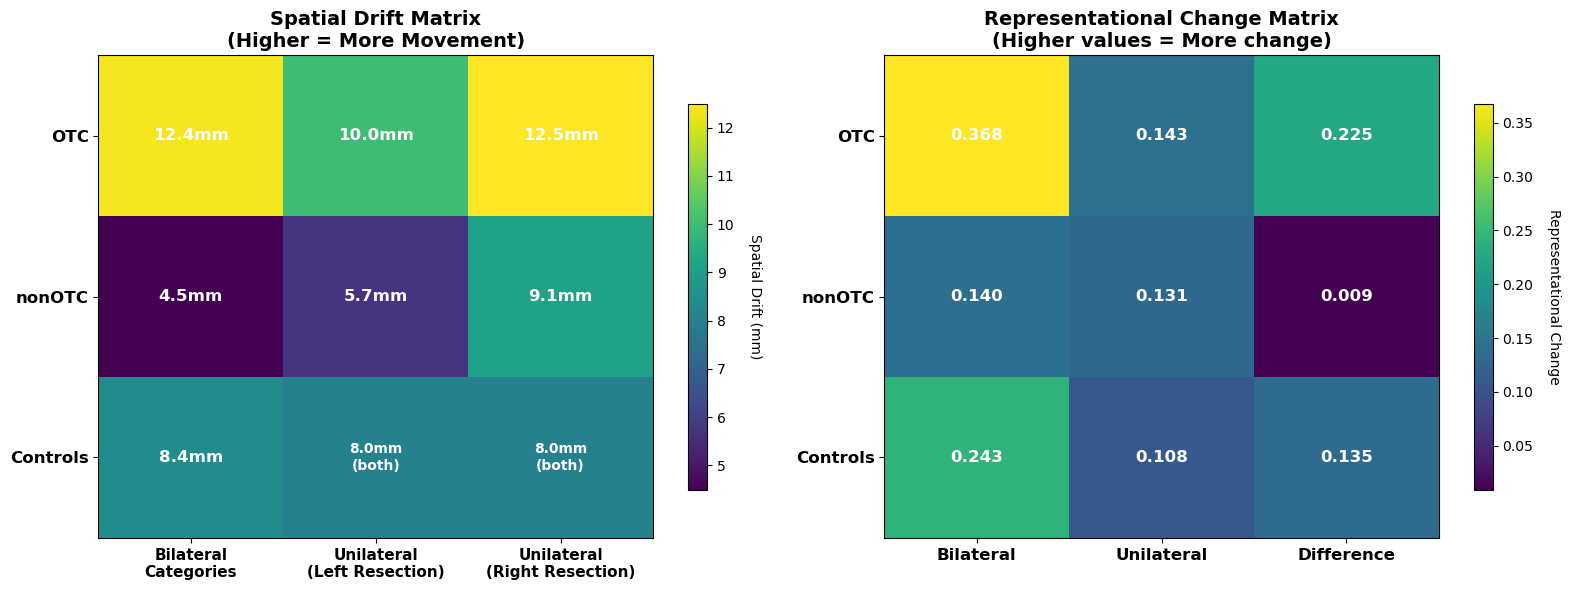

(array([[12.4, 10. , 12.5],
        [ 4.5,  5.7,  9.1],
        [ 8.4,  8. ,  8. ]]),
 array([[0.368, 0.143, 0.225],
        [0.14 , 0.131, 0.009],
        [0.243, 0.108, 0.135]]))

In [26]:
# CELL: Flipped Panel Order - Drift First, Then RSA
def create_flipped_plasticity_matrices():
    """Spatial drift on left, representational change on right"""
    
    # Same data as before
    repr_data = {
        'OTC': {'Bilateral': 0.368, 'Unilateral': 0.143, 'Difference': 0.225},
        'nonOTC': {'Bilateral': 0.140, 'Unilateral': 0.131, 'Difference': 0.009},
        'Controls': {'Bilateral': 0.243, 'Unilateral': 0.108, 'Difference': 0.135}
    }
    
    drift_data = {
        'OTC': {
            'Bilateral': 12.4, 
            'Unilateral_L': 10.0,  # (12.5 + 7.5) / 2
            'Unilateral_R': 12.5   # (3.7 + 21.3) / 2
        },
        'nonOTC': {
            'Bilateral': 4.5, 
            'Unilateral_L': 5.7,   # (9.5 + 1.8) / 2
            'Unilateral_R': 9.1    # (3.9 + 14.2) / 2
        },
        'Controls': {'Bilateral': 8.4, 'Unilateral': 8.0}
    }
    
    groups = ['OTC', 'nonOTC', 'Controls']
    repr_categories = ['Bilateral', 'Unilateral', 'Difference']
    
    # Create matrices
    repr_matrix = np.array([[repr_data[group][category] for category in repr_categories] for group in groups])
    
    drift_matrix = np.zeros((3, 3))
    for i, group in enumerate(groups):
        if group == 'Controls':
            drift_matrix[i] = [drift_data[group]['Bilateral'], drift_data[group]['Unilateral'], drift_data[group]['Unilateral']]
        else:
            drift_matrix[i] = [drift_data[group]['Bilateral'], drift_data[group]['Unilateral_L'], drift_data[group]['Unilateral_R']]
    
    # FLIPPED: Drift on left (ax1), RSA on right (ax2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Spatial Drift Matrix (LEFT PANEL)
    im1 = ax1.imshow(drift_matrix, cmap='viridis', aspect='auto')
    
    for i in range(len(groups)):
        for j in range(3):
            if groups[i] == 'Controls' and j > 0:
                text = ax1.text(j, i, f'{drift_matrix[i, j]:.1f}mm\n(both)', ha="center", va="center", 
                               color="white", fontweight='bold', fontsize=10)
            else:
                text = ax1.text(j, i, f'{drift_matrix[i, j]:.1f}mm', ha="center", va="center", 
                               color="white", fontweight='bold', fontsize=12)
    
    ax1.set_xticks([0, 1, 2])
    ax1.set_yticks(range(len(groups)))
    ax1.set_xticklabels(['Bilateral\nCategories', 'Unilateral\n(Left Resection)', 'Unilateral\n(Right Resection)'], 
                       fontsize=11, fontweight='bold')
    ax1.set_yticklabels(groups, fontsize=12, fontweight='bold')
    ax1.set_title('Spatial Drift Matrix\n(Higher = More Movement)', 
                  fontsize=14, fontweight='bold')
    
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Spatial Drift (mm)', rotation=270, labelpad=20)
    
    # Plot 2: Representational Change Matrix (RIGHT PANEL)
    im2 = ax2.imshow(repr_matrix, cmap='viridis', aspect='auto')
    
    for i in range(len(groups)):
        for j in range(len(repr_categories)):
            text = ax2.text(j, i, f'{repr_matrix[i, j]:.3f}', ha="center", va="center", 
                           color="white", fontweight='bold', fontsize=12)
    
    ax2.set_xticks(range(len(repr_categories)))
    ax2.set_yticks(range(len(groups)))
    ax2.set_xticklabels(repr_categories, fontsize=12, fontweight='bold')
    ax2.set_yticklabels(groups, fontsize=12, fontweight='bold')
    ax2.set_title('Representational Change Matrix\n(Higher values = More change)', 
                  fontsize=14, fontweight='bold')
    
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Representational Change', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    return drift_matrix, repr_matrix

# Create flipped visualization
create_flipped_plasticity_matrices()

COMPLETE HEMISPHERE × CATEGORY × GROUP BREAKDOWN

OTC GROUP:
------------------------------
  Face - Left resection: n=2
    Spatial drift: 12.5mm
    Repr change: 0.158
  Face - Right resection: n=3
    Spatial drift: 3.7mm
    Repr change: 0.218
  Word - Left resection: n=2
    Spatial drift: 7.5mm
    Repr change: 0.041
  Word - Right resection: n=3
    Spatial drift: 21.3mm
    Repr change: 0.125

nonOTC GROUP:
------------------------------
  Face - Left resection: n=5
    Spatial drift: 9.5mm
    Repr change: 0.089
  Face - Right resection: n=4
    Spatial drift: 3.9mm
    Repr change: 0.078
  Word - Left resection: n=5
    Spatial drift: 1.8mm
    Repr change: 0.123
  Word - Right resection: n=4
    Spatial drift: 14.2mm
    Repr change: 0.248


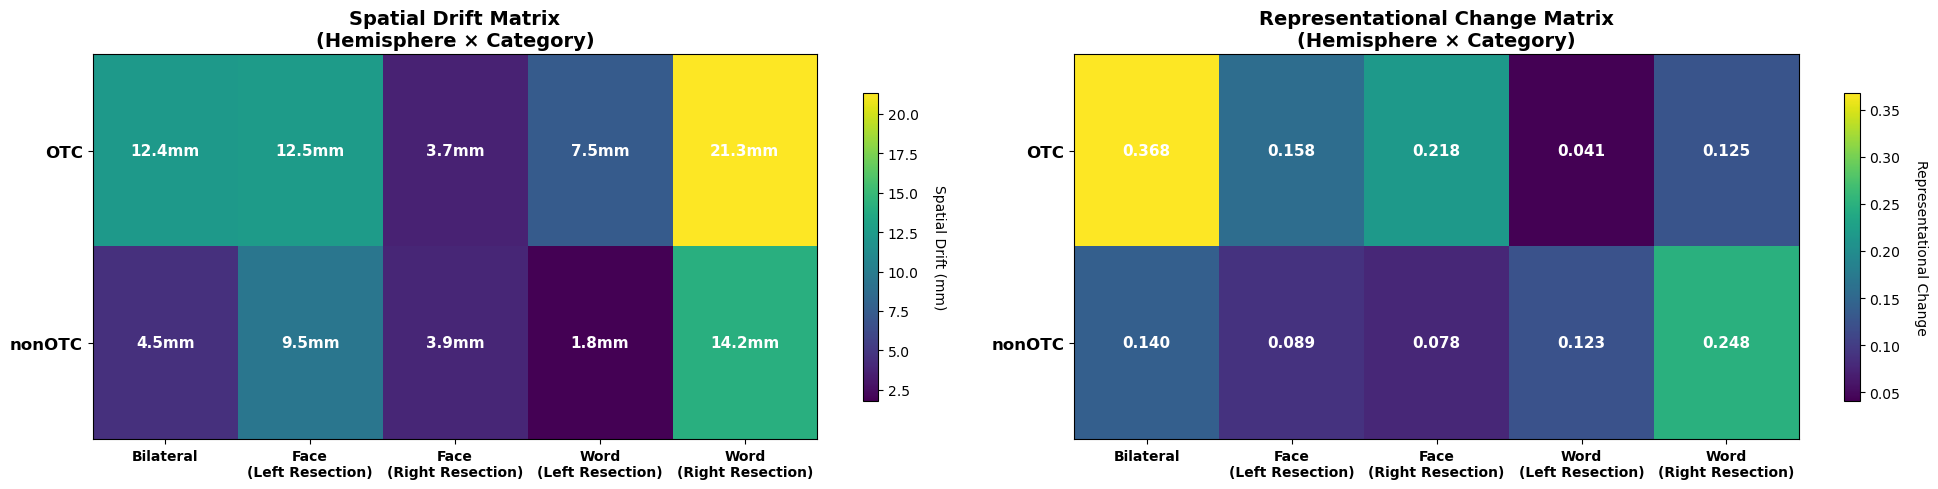


HEMISPHERE × CATEGORY SUMMARY:

OTC:
  Bilateral: spatial=12.4mm, repr=0.368
  Face (Left resection): spatial=12.5mm, repr=0.158
  Face (Right resection): spatial=3.7mm, repr=0.218
  Word (Left resection): spatial=7.5mm, repr=0.041
  Word (Right resection): spatial=21.3mm, repr=0.125

nonOTC:
  Bilateral: spatial=4.5mm, repr=0.140
  Face (Left resection): spatial=9.5mm, repr=0.089
  Face (Right resection): spatial=3.9mm, repr=0.078
  Word (Left resection): spatial=1.8mm, repr=0.123
  Word (Right resection): spatial=14.2mm, repr=0.248


In [24]:
# CELL: Calculate BOTH Spatial Drift and Representational Change by Hemisphere × Category
def calculate_complete_hemisphere_breakdown(results_table, analysis_subjects):
    """Calculate both spatial drift AND representational change by hemisphere × category"""
    
    # Clean data
    clean_data = results_table[results_table['Category_Type'] != 'Summary'].copy()
    
    complete_results = {}
    
    print("COMPLETE HEMISPHERE × CATEGORY × GROUP BREAKDOWN")
    print("="*70)
    
    for group in ['OTC', 'nonOTC']:
        group_data = clean_data[clean_data['Group'] == group]
        complete_results[group] = {}
        
        print(f"\n{group} GROUP:")
        print("-" * 30)
        
        for category in ['Face', 'Word']:
            category_data = group_data[group_data['Category'] == category]
            complete_results[group][category] = {}
            
            for hemi in ['l', 'r']:
                hemi_data = category_data[category_data['Hemisphere'] == hemi]
                
                if len(hemi_data) > 0:
                    mean_spatial = hemi_data['Spatial_Drift_mm'].mean()
                    mean_repr = hemi_data['Representational_Change'].mean()
                    n_subjects = len(hemi_data)
                    
                    hemi_name = 'Left resection' if hemi == 'l' else 'Right resection'
                    print(f"  {category} - {hemi_name}: n={n_subjects}")
                    print(f"    Spatial drift: {mean_spatial:.1f}mm")
                    print(f"    Repr change: {mean_repr:.3f}")
                    
                    complete_results[group][category][hemi] = {
                        'n': n_subjects,
                        'spatial_drift': mean_spatial,
                        'repr_change': mean_repr
                    }
                else:
                    print(f"  {category} - {hemi}: No data")
    
    return complete_results

def create_dual_hemisphere_matrices(complete_results):
    """Create both spatial drift AND representational change matrices with hemisphere breakdown"""
    
    # Extract data for matrices
    groups = ['OTC', 'nonOTC']
    
    # Get bilateral data from your original analysis
    bilateral_data = {
        'OTC': {'spatial': 12.4, 'repr': 0.368},
        'nonOTC': {'spatial': 4.5, 'repr': 0.140}
    }
    
    # Build matrices
    spatial_matrix = []
    repr_matrix = []
    
    for group in groups:
        spatial_row = [bilateral_data[group]['spatial']]
        repr_row = [bilateral_data[group]['repr']]
        
        # Add face and word data by hemisphere
        for category in ['Face', 'Word']:
            for hemi in ['l', 'r']:
                if (category in complete_results[group] and 
                    hemi in complete_results[group][category]):
                    spatial_row.append(complete_results[group][category][hemi]['spatial_drift'])
                    repr_row.append(complete_results[group][category][hemi]['repr_change'])
                else:
                    spatial_row.append(np.nan)
                    repr_row.append(np.nan)
        
        spatial_matrix.append(spatial_row)
        repr_matrix.append(repr_row)
    
    spatial_matrix = np.array(spatial_matrix)
    repr_matrix = np.array(repr_matrix)
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    # Plot 1: Spatial Drift Matrix
    im1 = ax1.imshow(spatial_matrix, cmap='viridis', aspect='auto')
    
    for i in range(len(groups)):
        for j in range(5):
            if not np.isnan(spatial_matrix[i, j]):
                text = ax1.text(j, i, f'{spatial_matrix[i, j]:.1f}mm', ha="center", va="center", 
                               color="white", fontweight='bold', fontsize=11)
    
    ax1.set_xticks([0, 1, 2, 3, 4])
    ax1.set_yticks(range(len(groups)))
    ax1.set_xticklabels(['Bilateral', 'Face\n(Left Resection)', 'Face\n(Right Resection)', 
                        'Word\n(Left Resection)', 'Word\n(Right Resection)'], 
                       fontsize=10, fontweight='bold')
    ax1.set_yticklabels(groups, fontsize=12, fontweight='bold')
    ax1.set_title('Spatial Drift Matrix\n(Hemisphere × Category)', fontsize=14, fontweight='bold')
    
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Spatial Drift (mm)', rotation=270, labelpad=20)
    
    # Plot 2: Representational Change Matrix  
    im2 = ax2.imshow(repr_matrix, cmap='viridis', aspect='auto')
    
    for i in range(len(groups)):
        for j in range(5):
            if not np.isnan(repr_matrix[i, j]):
                text = ax2.text(j, i, f'{repr_matrix[i, j]:.3f}', ha="center", va="center", 
                               color="white", fontweight='bold', fontsize=11)
    
    ax2.set_xticks([0, 1, 2, 3, 4])
    ax2.set_yticks(range(len(groups)))
    ax2.set_xticklabels(['Bilateral', 'Face\n(Left Resection)', 'Face\n(Right Resection)', 
                        'Word\n(Left Resection)', 'Word\n(Right Resection)'], 
                       fontsize=10, fontweight='bold')
    ax2.set_yticklabels(groups, fontsize=12, fontweight='bold')
    ax2.set_title('Representational Change Matrix\n(Hemisphere × Category)', fontsize=14, fontweight='bold')
    
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Representational Change', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    print(f"\nHEMISPHERE × CATEGORY SUMMARY:")
    print("="*40)
    
    for group in groups:
        print(f"\n{group}:")
        print(f"  Bilateral: spatial={bilateral_data[group]['spatial']:.1f}mm, repr={bilateral_data[group]['repr']:.3f}")
        
        for category in ['Face', 'Word']:
            if category in complete_results[group]:
                for hemi in ['l', 'r']:
                    if hemi in complete_results[group][category]:
                        data = complete_results[group][category][hemi]
                        hemi_name = 'Left' if hemi == 'l' else 'Right'
                        print(f"  {category} ({hemi_name} resection): spatial={data['spatial_drift']:.1f}mm, repr={data['repr_change']:.3f}")
    
    return spatial_matrix, repr_matrix

# Run the complete analysis
complete_hemisphere_results = calculate_complete_hemisphere_breakdown(results_table_complete, ANALYSIS_SUBJECTS)

# Create dual matrices
spatial_matrix, repr_matrix = create_dual_hemisphere_matrices(complete_hemisphere_results)